# 3C286 polarimetric interferometry observation

In this notebook we study a polarimetric interferometry observation of the quasar [3C286](https://en.wikipedia.org/wiki/3C_286) done with two antennas from Allen Telescope Array on 2020-10-31.

3C286 is a bright, compact, polarized source, with a fractional polarized intensity of around 10% and a polarization angle of 33º over a wide range of frequencies, so it makes an ideal source for polarization calibration. It is the primary [polarization calibration for VLA](https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/modes/pol).

In this observation, 3C286 was observed over a large range of parallactic angles and on eight different frequencies between 1 and 8 GHz. The output of the observation was averaged self-correlations and cross-correlations from the two antennas, produced with two USRP N32x and GNU Radio. Here we process the output, calibrate the complex gains and D-terms (polarization leakage terms) and measure the source polarization fraction and angle.

The data has 256 channels (FFT bins) spanning 30.72 MHz and each data point corresponds to an averaging interval of 0.1 seconds. Each scan corresponds to 100 seconds, and then the frequency is changed.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gnuradio.blocks import parse_file_metadata
import pmt
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz, ICRS, ITRS, EarthLocation
import astropy.units as u
import astropy.constants as const
import scipy.linalg
import scipy.optimize

import pathlib

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'w'
nfft = 256
T = 0.1
samp_rate = 30.72e6
recording_length = 100 # recording length in seconds

Antenna locations are approximate from Google maps. Below we will use a hand-optimized baseline to phase the observations.

In [2]:
source = SkyCoord.from_name('3c 286')
antenna_1h = EarthLocation(lat = 40.816410*u.deg,
                           lon = -121.471828*u.deg,
                           height = 1000*u.m)
antenna_4g = EarthLocation(lat = 40.818316*u.deg,
                           lon = -121.470420*u.deg,
                           height = 1000*u.m)

The observation outputs are saved as GNU Radio metadata files with detached headers. Each file corresponds to a 100 second scan done at a particular frequency. This helper function reads the metadata from the header.

In [3]:
def read_meta(path):
    with open(str(path) + '.hdr', 'rb') as f:
        header = f.read(parse_file_metadata.HEADER_LENGTH)
        header = pmt.deserialize_str(header)
        header = parse_file_metadata.parse_header(header, False)
        extra = f.read(header['extra_len'])
    extra = pmt.deserialize_str(extra)
    parse_file_metadata.parse_extra_dict(extra, header, False)
    return header

For some reason some files have a zero instead of the correct timestamp in the metadata. In those cases we take the timestamp from the filename. The timestamp in the filename is not exact, but usually good to within one second.

In [4]:
def fix_timestamp(path, r):
    candidate = read_meta(path / (r + 'power_0'))['rx_time']
    if candidate != 0:
        # good timestamp
        return candidate
    # timestamp in meta in incorrect -> get from filename
    t = Time(r.split('_')[-2])
    t.format = 'unix'
    return t.value

In [5]:
path = pathlib.Path('/home/destevez/polarimetry/observations-2020-10-31/')
recordings = [p.name.replace('power_0', '') for p in path.glob('3c286_*_power_0')]
lo_freqs = [pmt.to_double(read_meta(path / (r + 'power_0'))['lo_freq']) for r in recordings]
frequencies = sorted(set(lo_freqs))
recordings = {f : sorted([r for ff,r in zip(lo_freqs, recordings) if ff == f]) for f in frequencies}
timestamps = {f : Time([fix_timestamp(path, r) for r in recordings[f]], format = 'unix')
               for f in frequencies}
freq_legend = [f'{f:.0f} MHz' for f in frequencies]
chan_legend = ['1hx', '1hy', '4gx', '4gy']
visib_legend = ['XX', 'XY', 'YX', 'YY']

The functions below are used to read the self-correlations (powers) and cross-correlations (cross-spectra) from the data files.

In [6]:
def observed_powers(r):
    p = [np.fromfile(path / (r + f'power_{j}'), dtype = 'float32').reshape((-1,nfft))
                    for j in range(4)]
    l = np.min([pp.shape[0] for pp in p])
    return np.array([pp[:l] for pp in p])

def observed_crossspectra(r):
    cr = [np.fromfile(path / (r + f'cross_{j}'), dtype = 'complex64').reshape((-1,nfft))
                    for j in range(1,5)]
    l = np.min([c.shape[0] for c in cr])
    return np.array([c[:l] for c in cr])

In [7]:
powers = {f : [observed_powers(r) for r in recordings[f]] for f in frequencies}
cross = {f: [observed_crossspectra(r) for r in recordings[f]] for f in frequencies}

Below we compute and plot the parallactic angle. Since the observation was done for two hours around transit, the parallactic angle coverage is quite large, of around 90 degrees.

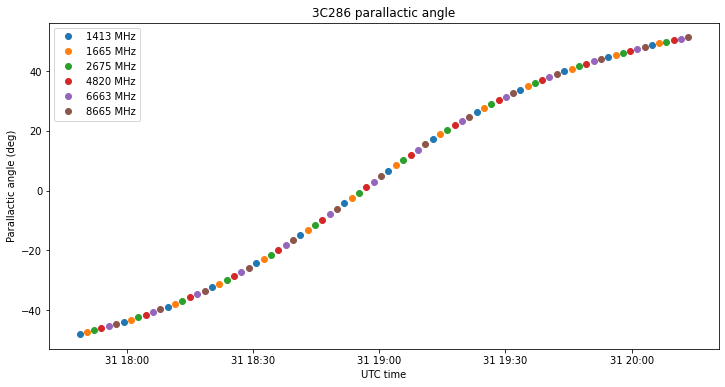

In [8]:
def compute_parallactic_angle(t):
    zenith = AltAz(alt = [90*u.deg for s in t], az = [0*u.deg for s in t],
                   location = antenna_1h, obstime = t)
    zenith = zenith.transform_to(ICRS)
    return source.position_angle(zenith)

midpoint_timestamps = {f : timestamps[f] + TimeDelta(recording_length/2, format = 'sec')
                      for f in frequencies}
parallactic_angle = {f : compute_parallactic_angle(midpoint_timestamps[f]) for f in frequencies}

for f in frequencies:
    plt.plot(midpoint_timestamps[f].datetime, parallactic_angle[f].wrap_at('180d').deg, 'o')
plt.legend(freq_legend)
plt.title('3C286 parallactic angle')
plt.ylabel('Parallactic angle (deg)')
plt.xlabel('UTC time');

The code below phases the observations to the source, to stop the fringe rotation, so that data can be averaged. The baseline comes from some previous interferometric observations with these antennas at a frequency of 1.4 GHz, and is hand-optimized further for this particular observation and set of frequencies.

UVW coordinates for each data point are also calculated here. These are not used in this notebook but are required to export the data to UVFITS format, in order to load them in CASA and compare the results obtained here with the calibration solution obtained with CASA.

In [9]:
baseline_itrs = [-172.93166+0.2, -56.959799+0.2, -159.80786]*u.m

north_radec = [source.ra.deg, source.dec.deg + 90]
if north_radec[1] > 90:
    north_radec[1] = 180 - north_radec[1]
    north_radec[0] = 180 + north_radec[0]
north = SkyCoord(ra = north_radec[0]*u.deg, dec = north_radec[1]*u.deg)

def stop_baseline(t0, cross, freq, delay_offset = 22.3):
    f_obs = freq * 1e6 * u.Hz
    f_samp = samp_rate * u.Hz
    ts = t0 + TimeDelta(T, format = 'sec') * np.arange(cross.shape[1])
    source_itrs = source.transform_to(ITRS(obstime = Time(ts))).cartesian
    north_itrs = north.transform_to(ITRS(obstime = Time(ts))).cartesian
    east_itrs = north_itrs.cross(source_itrs)
    ww = source_itrs.xyz.T.dot(baseline_itrs)
    vv = north_itrs.xyz.T.dot(baseline_itrs)
    uu = east_itrs.xyz.T.dot(baseline_itrs)
    w_cycles = (ww/const.c*f_obs).to(1).value
    w_samples = (ww/const.c*f_samp).to(1).value
    return (cross * np.exp(-1j*2*np.pi*w_cycles)[:,np.newaxis] \
                    * np.exp(1j*2*np.pi*(delay_offset - w_samples[:,np.newaxis])/nfft*np.arange(nfft)),
            np.array([uu.value,vv.value,ww.value]))

In [10]:
stopped = {f: [stop_baseline(t0, cr, f) for t0, cr in zip(timestamps[f],cross[f])]
                 for f in frequencies}
cross_stopped = {f : [a[0] for a in stopped[f]] for f in frequencies}
uvw = {f : [a[1] for a in stopped[f]] for f in frequencies}

Some data obtained in the previous step is now saved to Numpy files. These are loaded in another script which performs the export to UVFITS format.

In [11]:
for f in frequencies:
    np.savez(f'/home/destevez/3c286_uv/uv.{f:.0f}.npz', *cross_stopped[f])
    np.savez(f'/home/destevez/3c286_uv/uvw.{f:.0f}.npz', *uvw[f])
    np.save(f'/home/destevez/3c286_uv/jd.{f:.0f}.npy', timestamps[f].jd)

Below we plot the normalized average and maximum power spectrum of each of scan. This helps us check the quality of the data and see any possible RFI. There is very strong RFI in the 1665 MHz scans. The HI-line is visible in the 1413 MHz scans.

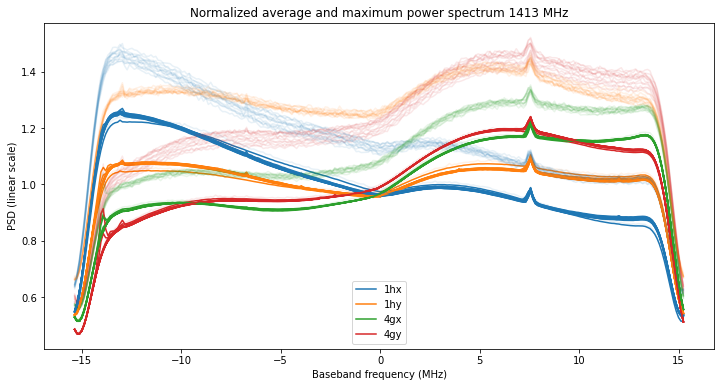

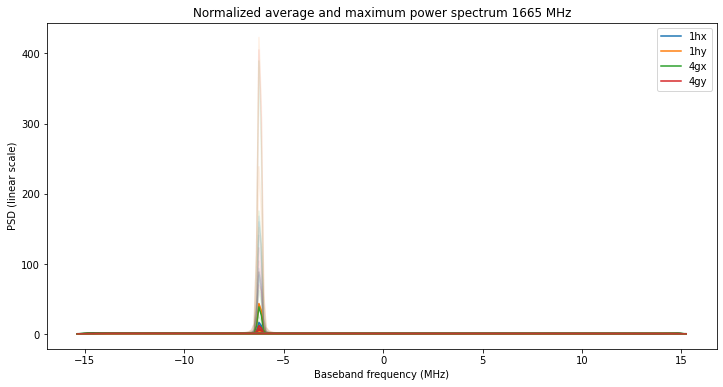

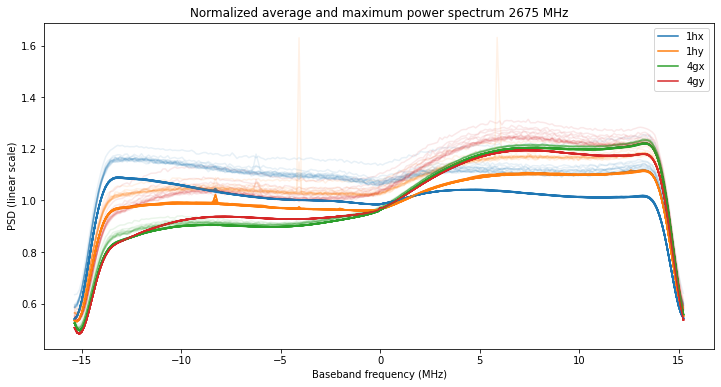

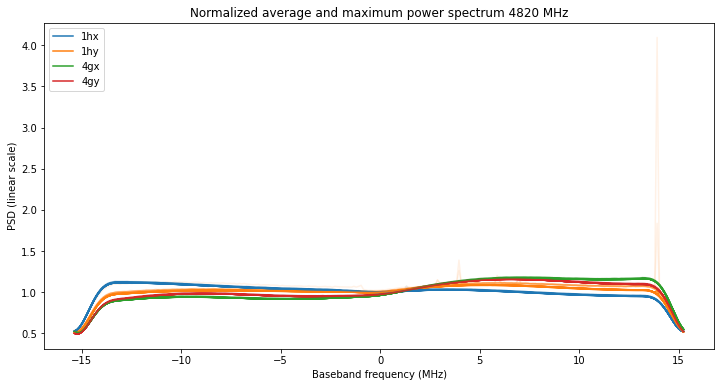

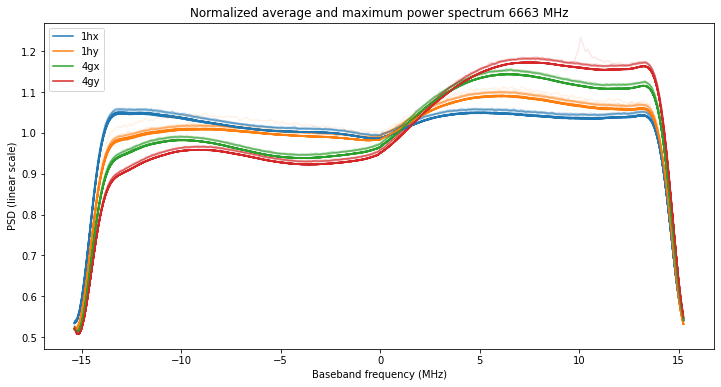

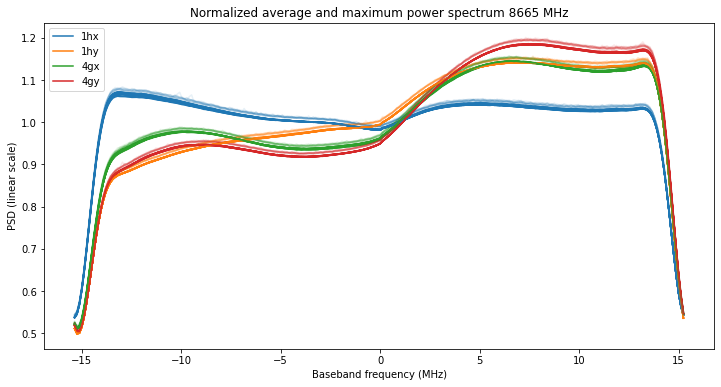

In [12]:
avg = 10
faxis = np.fft.fftshift(np.fft.fftfreq(nfft, 1/samp_rate)) * 1e-6
for f in frequencies:
    plt.figure()
    for pwr in powers[f]:
        avg_pwr = np.average(pwr, axis = 1)
        avg_short_pwr = np.average(pwr[:,:pwr.shape[1]//avg*avg].reshape((pwr.shape[0], -1, avg, pwr.shape[2])),
                                    axis = 2)
        max_pwr = np.max(avg_short_pwr, axis = 1)
        plt.gca().set_prop_cycle(None)
        plt.plot(faxis, (avg_pwr/np.average(avg_pwr, axis = 1)[:,np.newaxis]).T)
        plt.gca().set_prop_cycle(None)
        plt.plot(faxis, (max_pwr/np.average(avg_pwr, axis = 1)[:,np.newaxis]).T, alpha = 0.1)
    plt.title(f'Normalized average and maximum power spectrum {f:.0f} MHz')
    plt.ylabel('PSD (linear scale)')
    plt.xlabel('Baseband frequency (MHz)')
    plt.legend(chan_legend)

We mask out the channels where strong RFI is present in the 1666 MHz scans.

In [13]:
spectral_mask = {f : np.ones(nfft) for f in frequencies}
spectral_mask[1665][58:95] = 0
for f in frequencies:
    for cr in cross_stopped[f]:
        cr *= spectral_mask[f]

We now plot several aspects of the XX correlation to check the quality of the fringe-stopping. Below we show the visibility phase. Interestingly, it seems that the baseline that matches the data is frequency dependent. The baseline we have considered above gives a very good match at 8.6 GHz, but the match gets worse as we get lower in frequency.

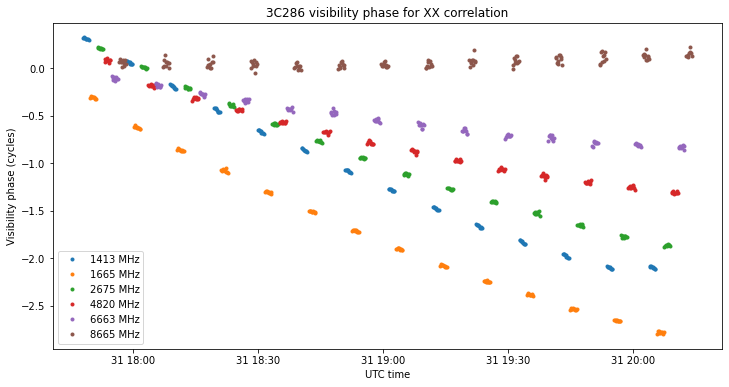

In [14]:
avg = 100
for f in frequencies:
    times = list()
    phases = list()
    for t0,cr in zip(timestamps[f],cross_stopped[f]):
        cr_avg = np.average(cr[0], axis = 1)
        cr_avg = np.average(cr_avg[:cr_avg.size//avg*avg].reshape((-1,avg)), axis = -1)
        t = t0 + TimeDelta(T*avg, format = 'sec') * np.arange(cr_avg.shape[-1])
        times.append(t)
        phases.append(np.angle(cr_avg))
    plt.plot(np.concatenate([t.datetime for t in times]), np.unwrap(np.concatenate(phases))/(2*np.pi), '.')
plt.legend(freq_legend)
plt.title('3C286 visibility phase for XX correlation')
plt.ylabel('Visibility phase (cycles)')
plt.xlabel('UTC time');

This is best shown in the next figure, which shows the phase residuals.

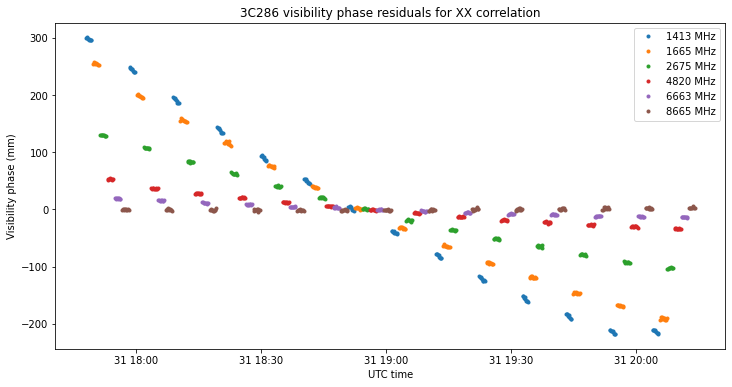

In [15]:
avg = 100
for f in frequencies:
    times = list()
    phases = list()
    for t0,cr in zip(timestamps[f],cross_stopped[f]):
        cr_avg = np.average(cr[0], axis = 1)
        cr_avg = np.average(cr_avg[:cr_avg.size//avg*avg].reshape((-1,avg)), axis = -1)
        t = t0 + TimeDelta(T*avg, format = 'sec') * np.arange(cr_avg.shape[-1])
        times.append(t)
        phases.append(np.angle(cr_avg))
    residual = np.unwrap(np.concatenate(phases))/(2*np.pi)*const.c.value/f*1e-3
    residual -= np.average(residual)
    plt.plot(np.concatenate([t.datetime for t in times]), residual, '.')
plt.legend(freq_legend)
plt.title('3C286 visibility phase residuals for XX correlation')
plt.ylabel('Visibility phase (mm)')
plt.xlabel('UTC time');

Below we show the normalized visibility amplitudes. We see that the SNR gets progressively worse as we increase the observation frequency. 3C286 has a brighness of around 15 Jy at 1.4 GHz, but it decreases to 7 Jy at 6.6 GHz. We also note that the amplitude dips slightly towards the middle of the observation.

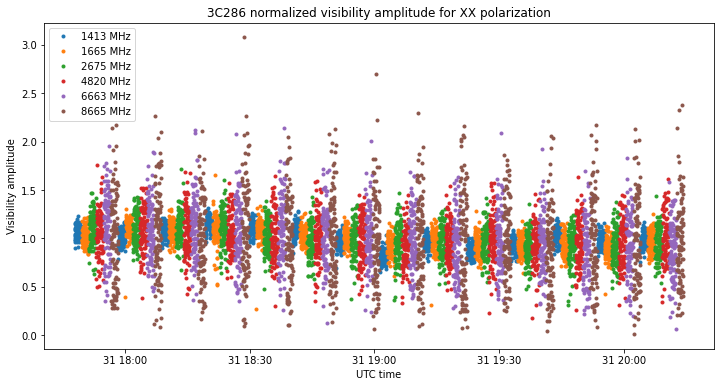

In [16]:
avg = 10
for f in frequencies:
    times = list()
    amplitudes = list()
    for t0,cr in zip(timestamps[f],cross_stopped[f]):
        cr_avg = np.average(cr[0], axis = 1)
        cr_avg = np.average(cr_avg[:cr_avg.size//avg*avg].reshape((-1,avg)), axis = -1)
        t = t0 + TimeDelta(T*avg, format = 'sec') * np.arange(cr_avg.shape[-1])
        times.append(t)
        amplitudes.append(np.abs(cr_avg))
    amplitude = np.concatenate(amplitudes)
    plt.plot(np.concatenate([t.datetime for t in times]), 
             amplitude/np.average(amplitude), '.')
plt.legend(freq_legend)
plt.title('3C286 normalized visibility amplitude for XX polarization')
plt.ylabel('Visibility amplitude')
plt.xlabel('UTC time');

The visibility phase accross the frequency channels show little slope, which indicates that there is little residual delay, so the data can be averaged over all the frequency channels without losses.

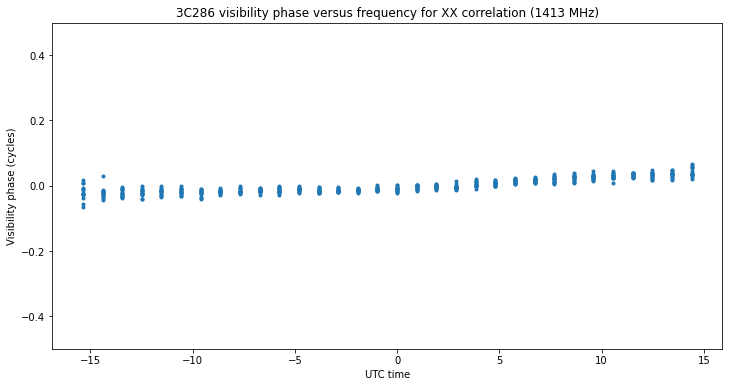

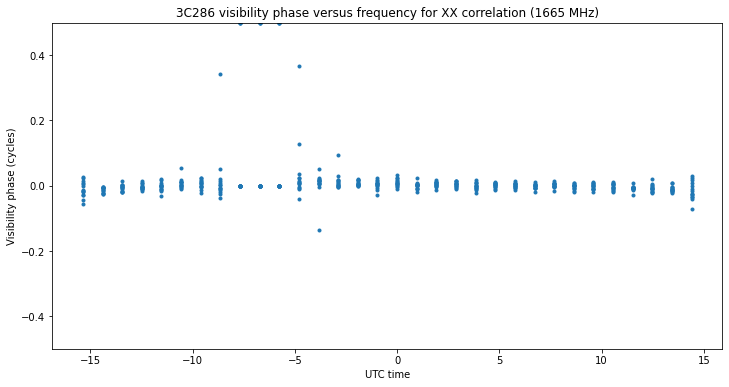

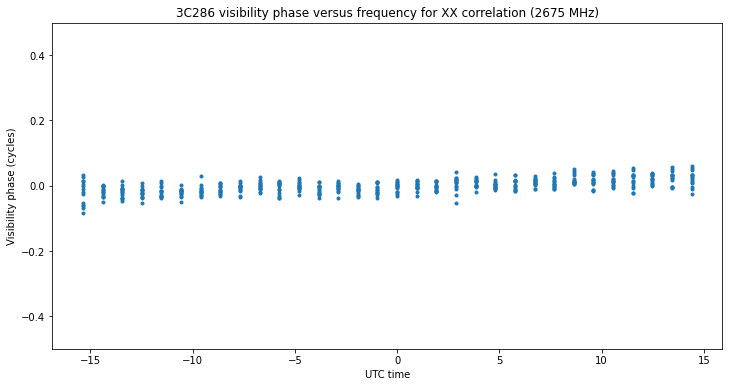

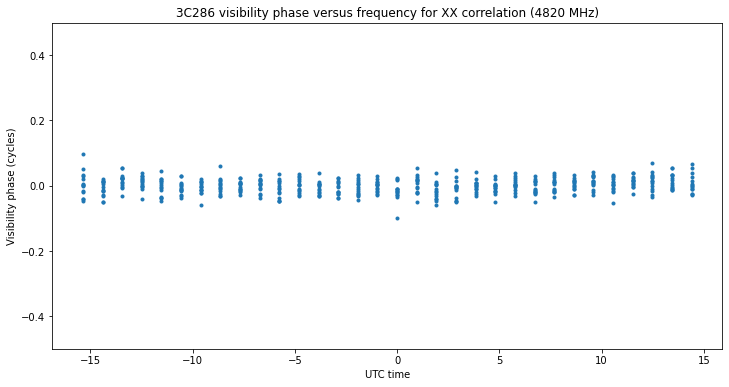

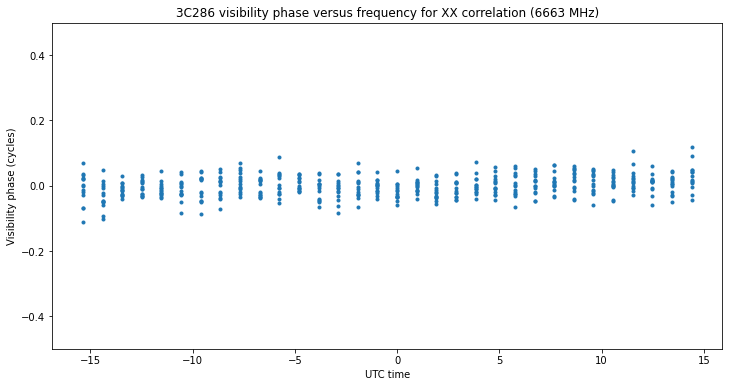

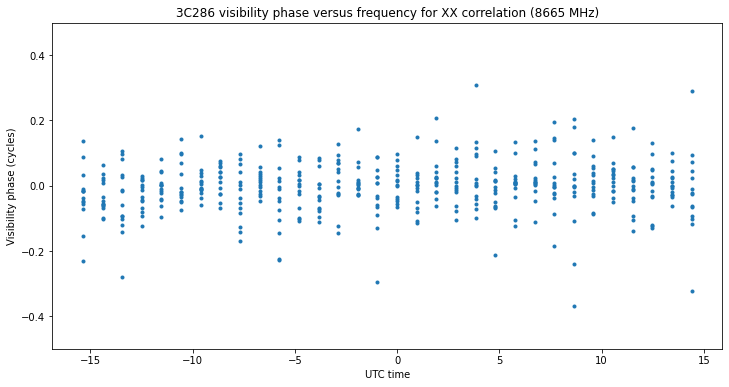

In [17]:
avg = 8
for f in frequencies:
    plt.figure()
    for cr in cross_stopped[f]:
        cr_avg = np.average(cr[0], axis = 0)
        cr_avg = np.average(cr_avg.reshape((-1,avg)), axis = -1)
        cr_avg *= np.exp(-1j * np.angle(np.average(cr_avg)))
        plt.plot(faxis[::avg], np.angle(cr_avg)/(2*np.pi), '.', color = 'C0')
    plt.ylim((-0.5,0.5))
    plt.title(f'3C286 visibility phase versus frequency for XX correlation ({f:.0f} MHz)')
    plt.ylabel('Visibility phase (cycles)')
    plt.xlabel('UTC time');

We now construct the visibilities we will work with. We average all the frequency channels and time segments in a scan, so that we obtain a single complex visibility for each scan.

In [18]:
V = {f : np.array([np.average(cr, axis = (1,2)) for cr in cross_stopped[f]])
     for f in frequencies}

Below we show the amplitudes of the visibilities at each observation frequency. Already it is possible to see how the XX correlation slopes downwards and the YY correlation slopes upwards as the apparent polarization angle of the source rotates on the sky rotates.

In fact, since the polarization angle of the source is 33º, the polarization direction will be aligned with the horizontal X polarization at a paralactic angle of -57º, some time before the beginning of the observation. The source will then keep rotating, passing and angle of 45º (so that both the X and Y polarizations see the same power) at a parallactic angle of -12º, at 18:44 UTC, and then be vertically aligned with the Y polarization at a parallactic angle of 33º, at 19:33 UTC.

Therefore, the XX amplitude should decrease between the beginning of the observation and 19:33 UTC, while the YY amplitude increases. After 19:33 the trend should reverse. It is not so easy to see this yet, because the XX and YY correlations have different instrumental gains and there are also large variations in gain that affect both channels.

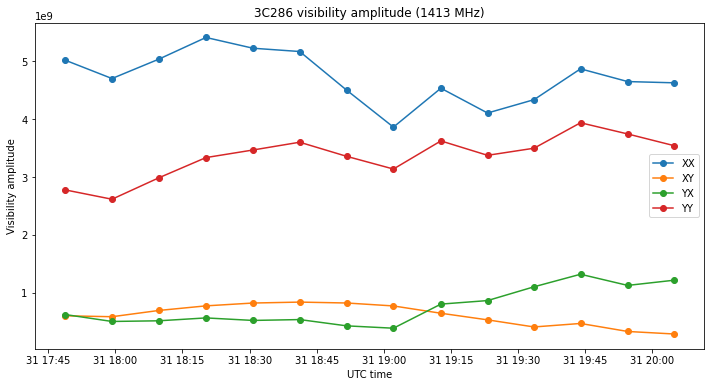

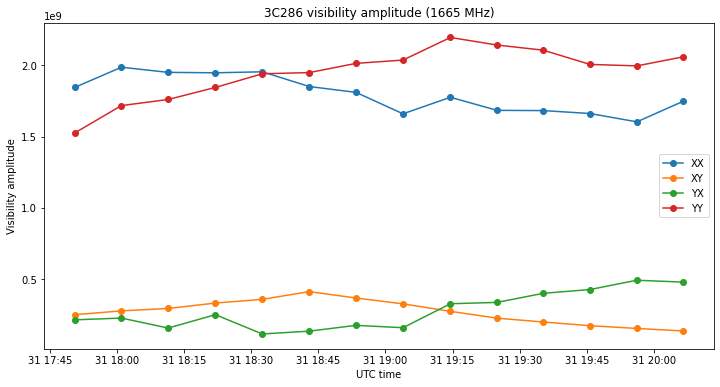

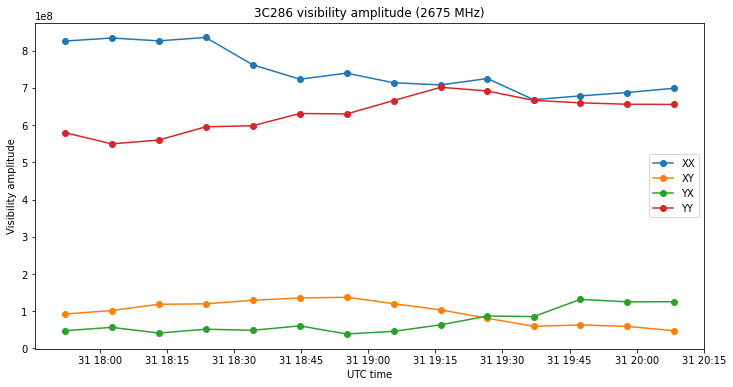

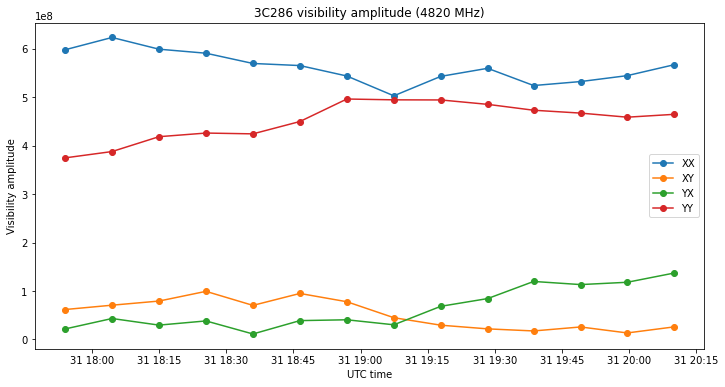

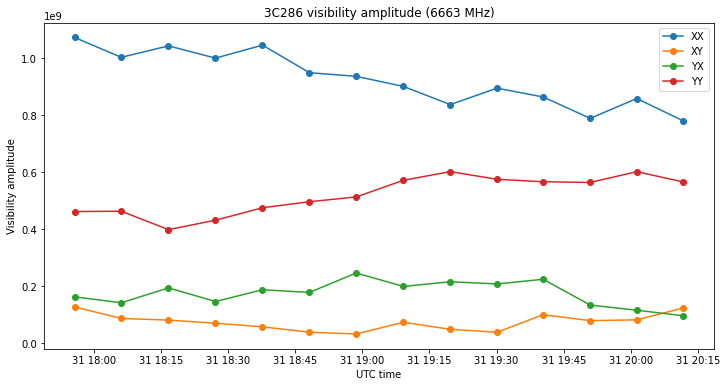

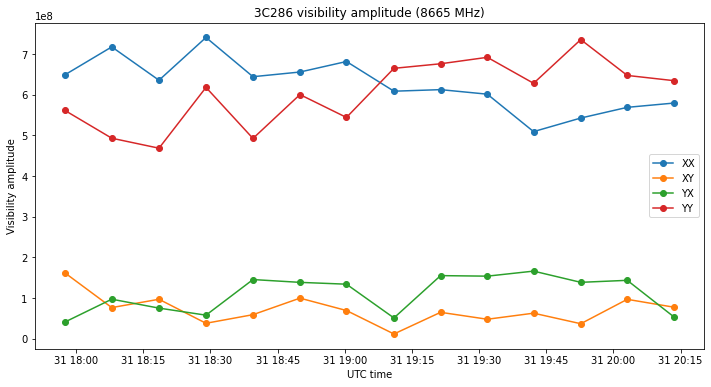

In [19]:
for f in frequencies:
    plt.figure()
    plt.plot(midpoint_timestamps[f].datetime, np.abs(V[f]), 'o-')
    plt.title(f'3C286 visibility amplitude ({f:.0f} MHz)')
    plt.ylabel('Visibility amplitude')
    plt.xlabel('UTC time')
    plt.legend(visib_legend)

First we calibrate out the instrumental gain difference between the X and Y channels. To do so, we use the self-correlations. We compute the average self-correlation power of each of the channels over all the observation and and divide each correlation by the geometric average of the powers of the channels involved in that correlation.

In [20]:
P = {f : np.array([np.average(pwr, axis = (1,2)) for pwr in powers[f]]) for f in frequencies}

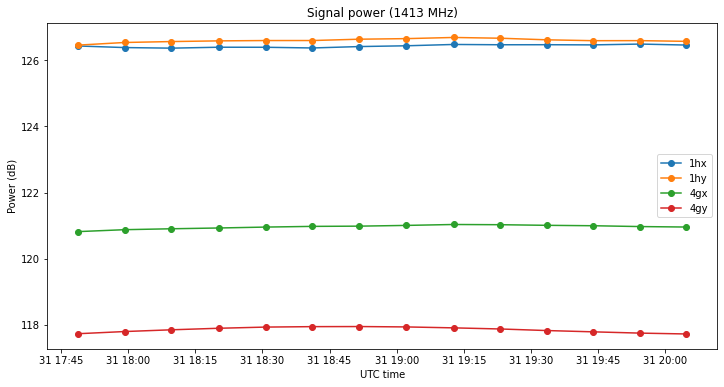

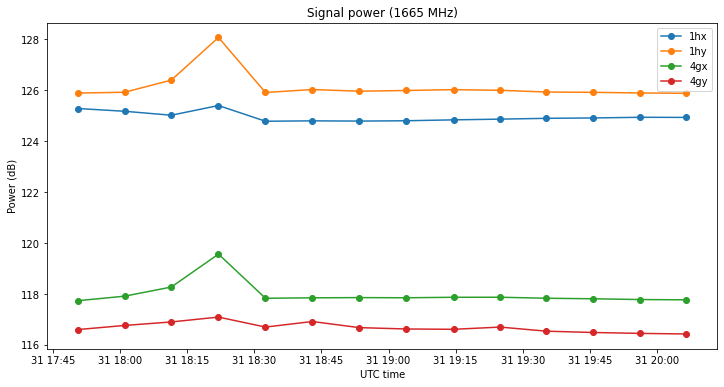

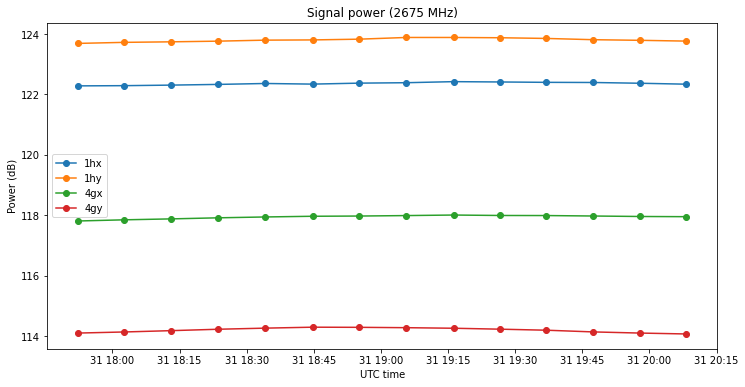

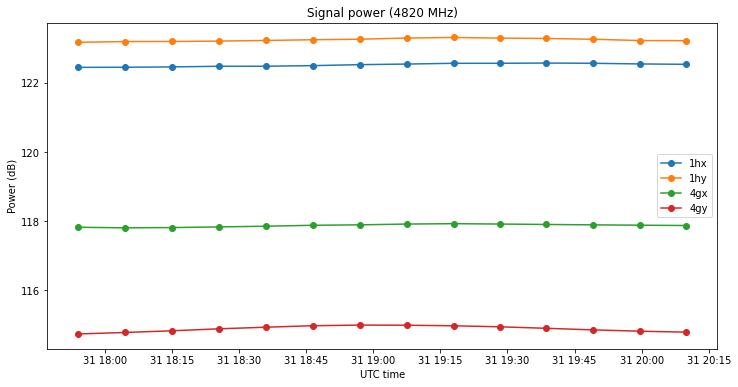

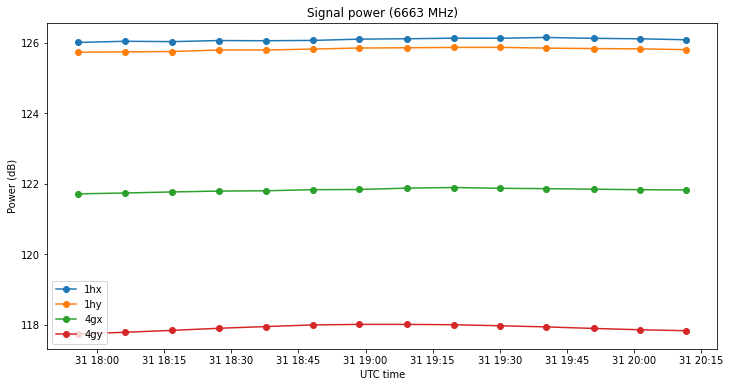

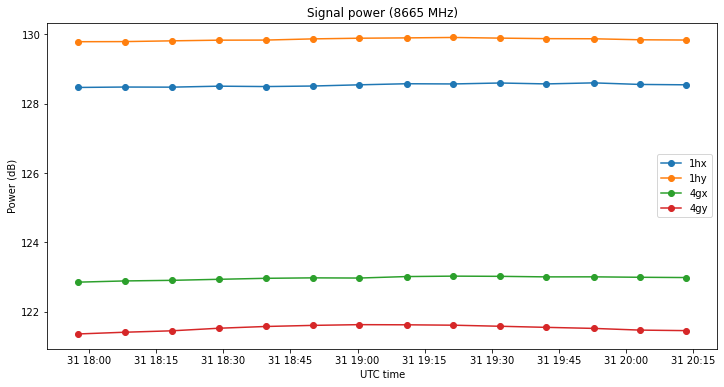

In [21]:
for f in frequencies:
    plt.figure()
    plt.plot(midpoint_timestamps[f].datetime, 10*np.log10(P[f]), 'o-')
    plt.title(f'Signal power ({f:.0f} MHz)')
    plt.ylabel('Power (dB)')
    plt.xlabel('UTC time')
    plt.legend(chan_legend);

In [22]:
g = {f : np.average(P[f], axis = 0) for f in frequencies}
g_corr = {f : 1/np.sqrt(np.array([g[f][0]*g[f][2], g[f][0]*g[f][3], g[f][1]*g[f][2], g[f][1]*g[f][3]]))
          for f in frequencies}
V1 = {f : g_corr[f][np.newaxis] * V[f] for f in frequencies}

The next calibration we do is to remove the phase offset between the XX and YY channels, so that XX and YY can be added together to give an approximation of Stokes I (the approximation comes from the fact that D-terms are still not considered). For each frequency, the phase offset is almost constant with time, so we just consider its average value over all the observation. We use the resulting calibration to rotate YY so that it has almost the same phase a XX.

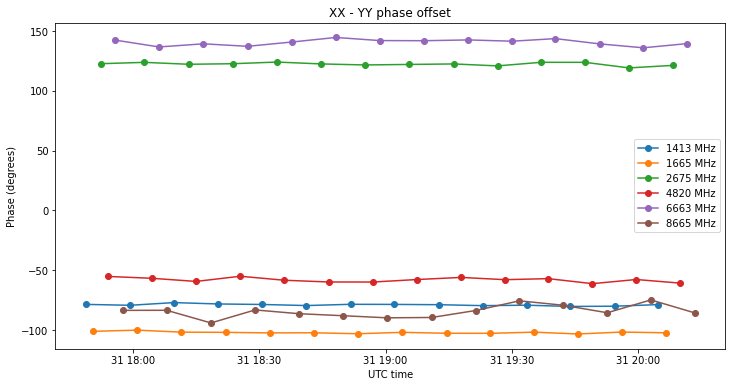

In [23]:
for f in frequencies:
    plt.plot(midpoint_timestamps[f].datetime, np.rad2deg(np.angle(V1[f][:,0]*np.conj(V1[f][:,3]))), 'o-')
    plt.title(f'XX - YY phase offset')
    plt.ylabel('Phase (degrees)')
    plt.xlabel('UTC time')
    plt.legend(freq_legend);

In [24]:
V2 = {f : V1[f].copy() for f in frequencies}
for f in frequencies:
    V2[f][:,3] *= np.exp(1j*np.average(np.angle(V1[f][:,0]*np.conj(V1[f][:,3]))))

Now that XX and YY have almost the same phase, can rotate all the correlations so that the phase of XX and YY becomes almost zero. We plot the resulting visibility phases below.

In [25]:
V3 = {f: V2[f] * np.exp(-1j*np.angle(V2[f][:,0] + V2[f][:,3]))[:,np.newaxis]
      for f in frequencies}

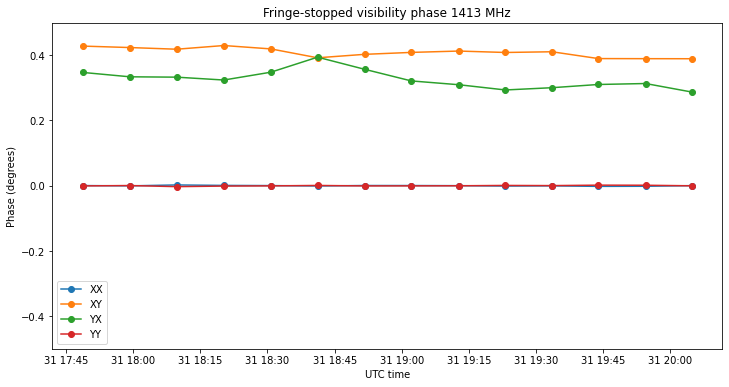

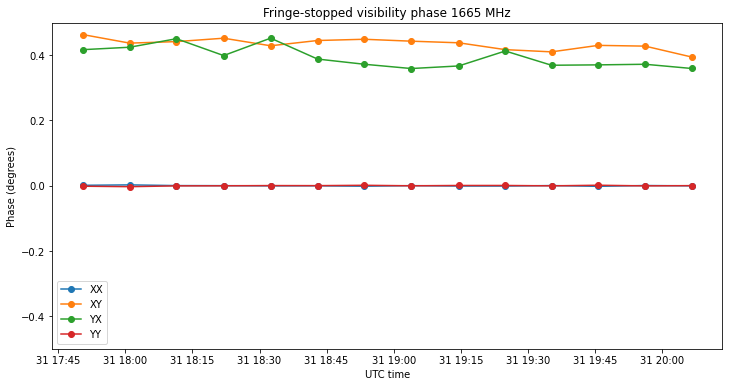

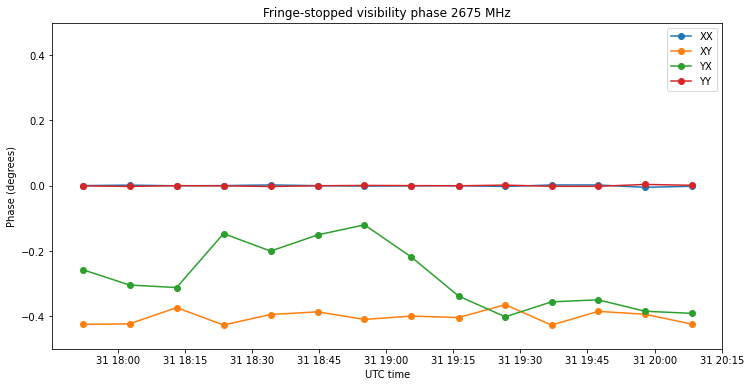

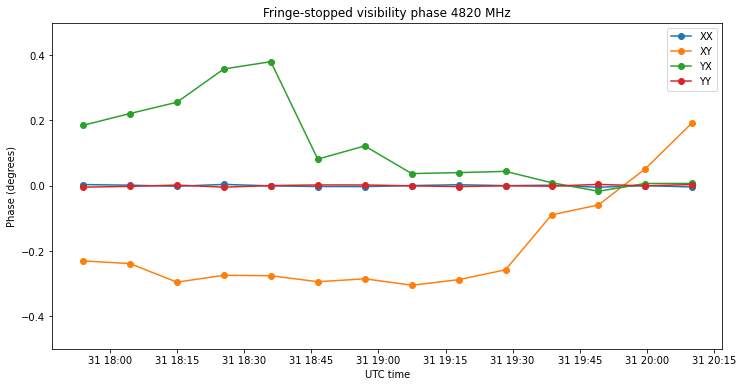

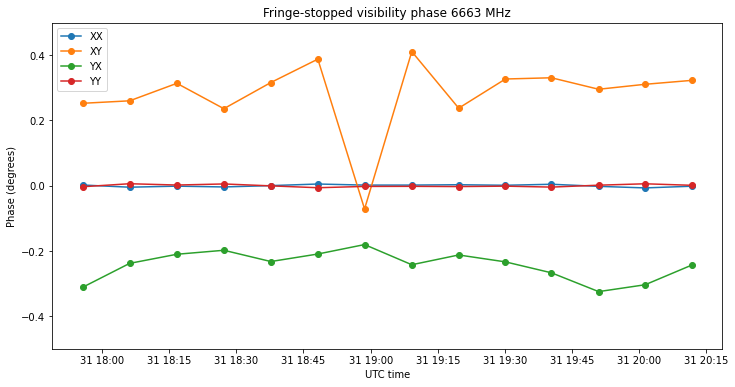

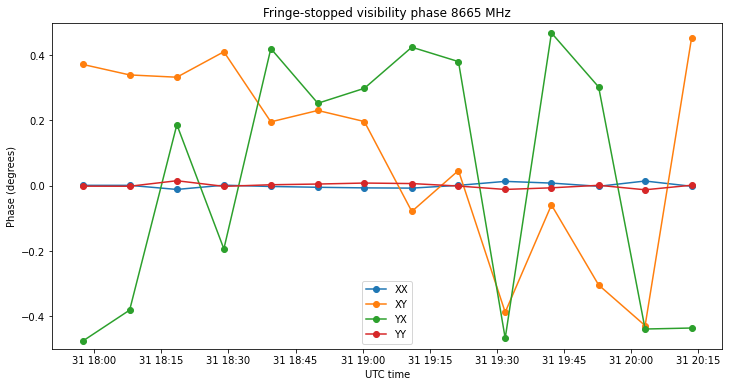

In [26]:
for f in frequencies:
    plt.figure()
    plt.plot(midpoint_timestamps[f].datetime, np.angle(V3[f])/(2*np.pi), 'o-')
    plt.ylim((-0.5,0.5))
    plt.title(f'Fringe-stopped visibility phase {f:.0f} MHz')
    plt.ylabel('Phase (degrees)')
    plt.xlabel('UTC time')
    plt.legend(visib_legend);

To remove the time varying gain changes that affect all the channels equally, we approximate Stokes I by XX + YY and divide each scan by Stokes I in order to normalize the visibilities. Now it is much easier to see the amplitude changes in the XX and YY channels caused by the source rotation.

In [27]:
V4 = {f: V3[f] / (V3[f][:,0] + V3[f][:,3])[:,np.newaxis]
      for f in frequencies}

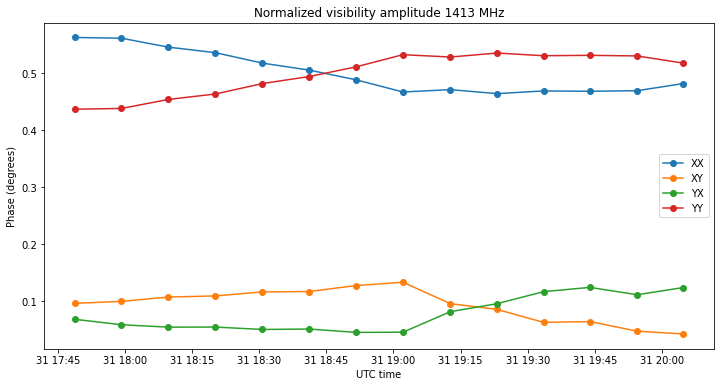

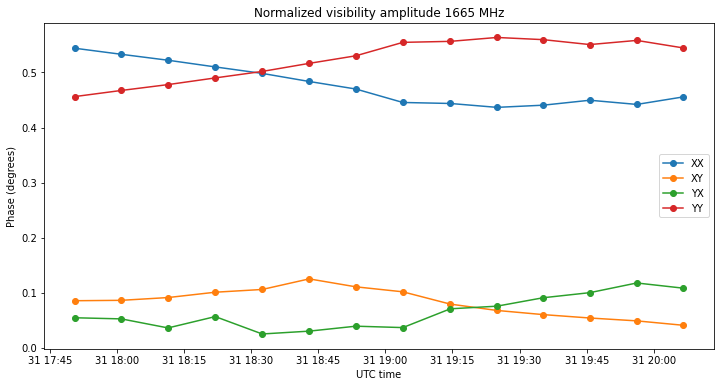

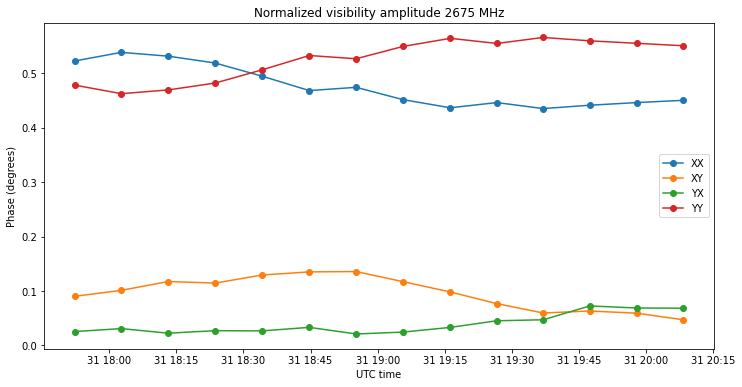

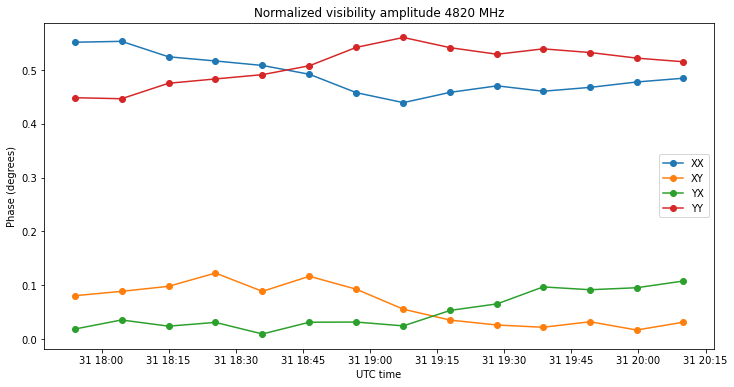

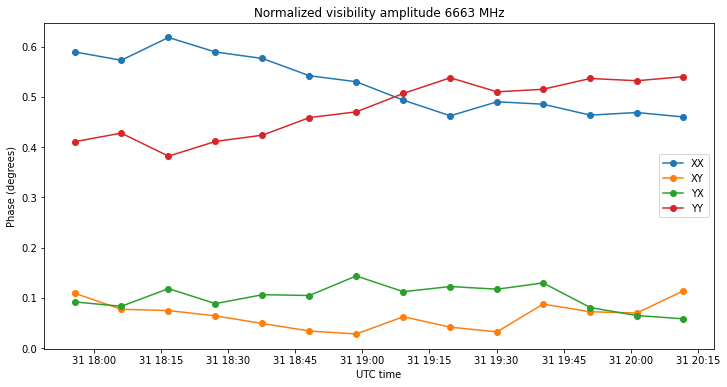

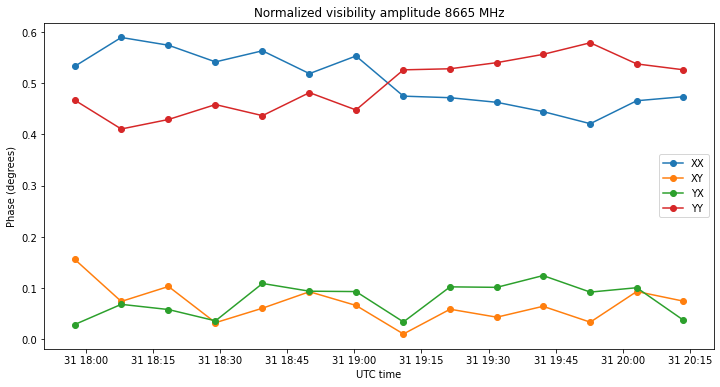

In [28]:
for f in frequencies:
    plt.figure()
    plt.plot(midpoint_timestamps[f].datetime, np.abs(V4[f]), 'o-')
    plt.title(f'Normalized visibility amplitude {f:.0f} MHz')
    plt.ylabel('Phase (degrees)')
    plt.xlabel('UTC time')
    plt.legend(visib_legend);

Now we start working with the cross-hand terms XY and YX. These are greately affected by the polarization leakage D-terms, because the D-terms are around 0.1, which is the same order of magnitude as the polarization source. Thus, it is important to calibrate out the D-terms. Besides the D-terms, we still have a phase difference between the X and Y channels. This causes the rotation of the cross-hand correlations.

The geometric idea to perform this calibration is as follows. If there were not instrumental effects, the cross-hand terms would be real and describe a sinusoid curve as the source rotates. The D-terms add an offset to the cross-hand terms in the complex plane, while the phase difference between X and Y rotates the whole picture. We must determine and correct these offsets and rotations.

Below we see the uncalibrated cross-hand visibilities. They are rather noisy, but we can see that they sort of move along a straight line. This is much clearer for the lower frequency bands.

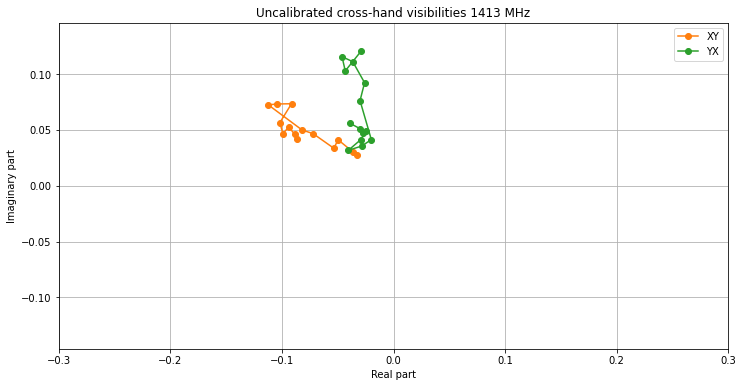

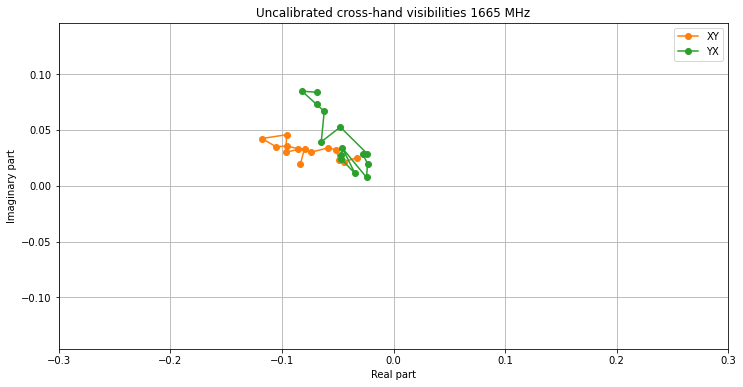

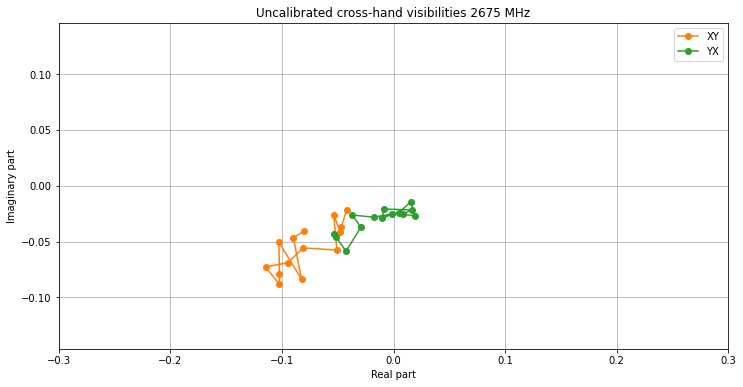

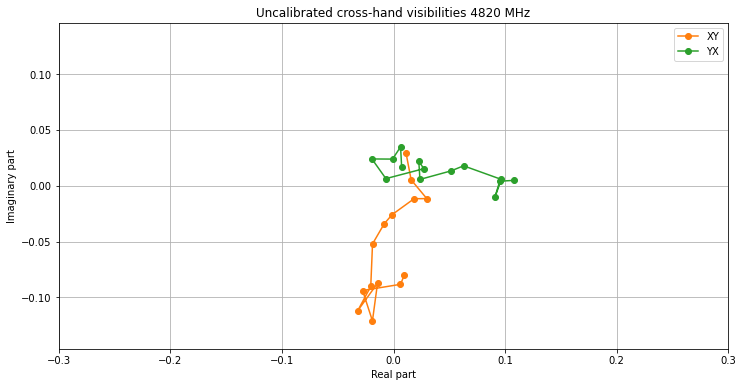

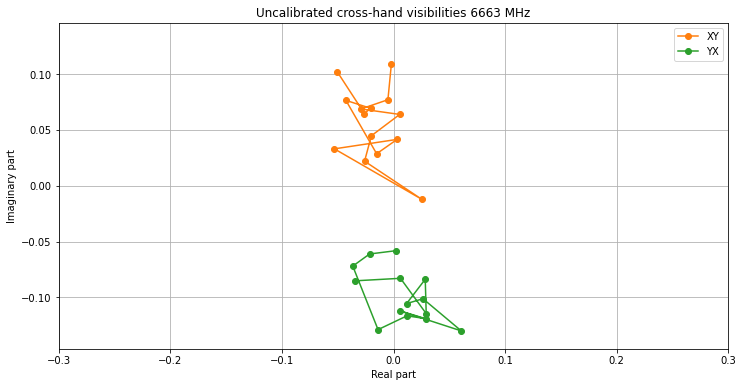

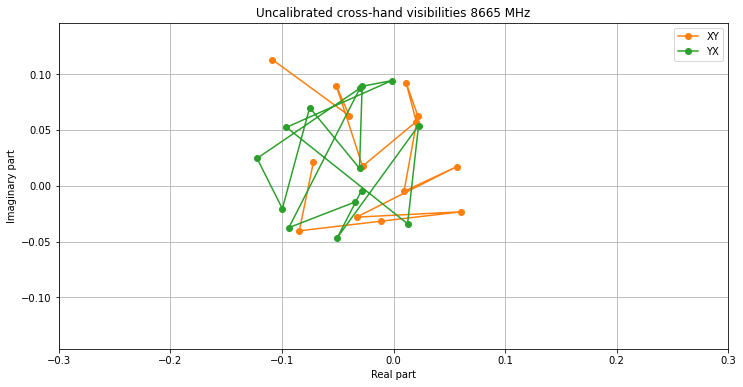

In [29]:
for f in frequencies:
    plt.figure()
    plt.plot(V4[f][:,1].real, V4[f][:,1].imag, 'o-', color = 'C1')
    plt.plot(V4[f][:,2].real, V4[f][:,2].imag, 'o-', color = 'C2')
    plt.axis('equal')
    a = 0.3
    plt.ylim((-a,a))
    plt.xlim((-a,a));
    plt.grid()
    plt.legend(visib_legend[1:-1])
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.title(f'Uncalibrated cross-hand visibilities {f:.0f} MHz')

We first subtract its average to each of the cross-hands to center it. Now each cross-hand lies on a line passing through the origin.

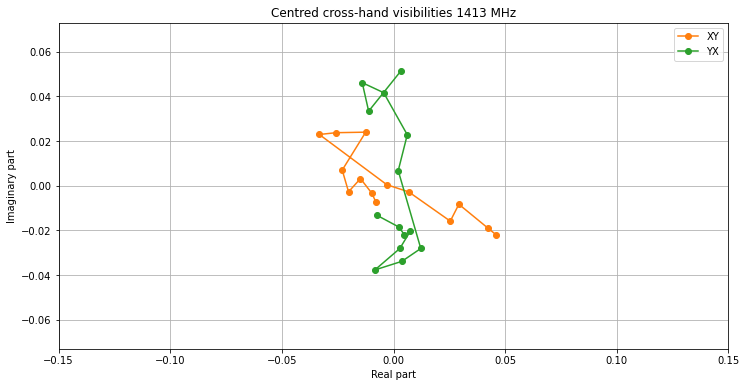

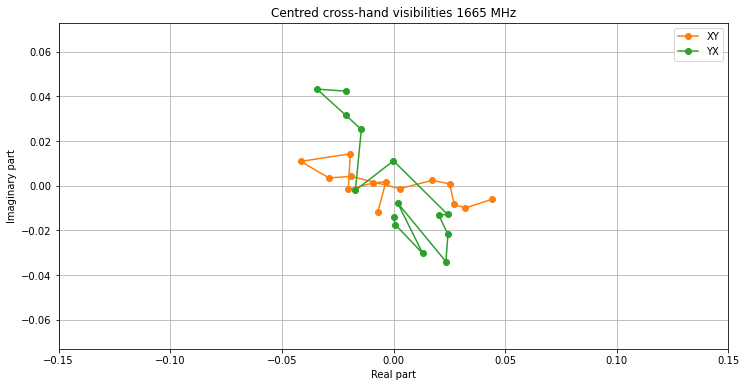

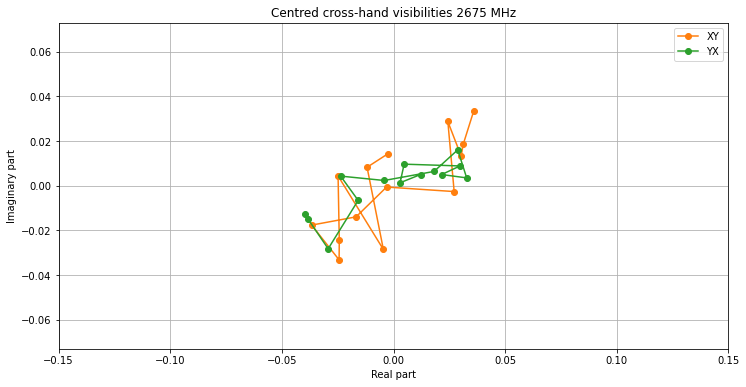

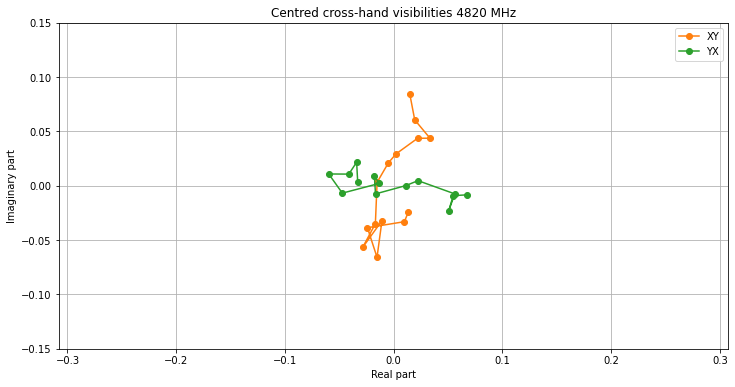

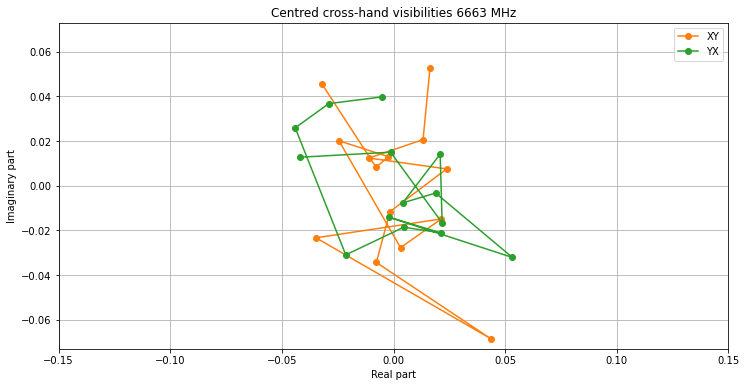

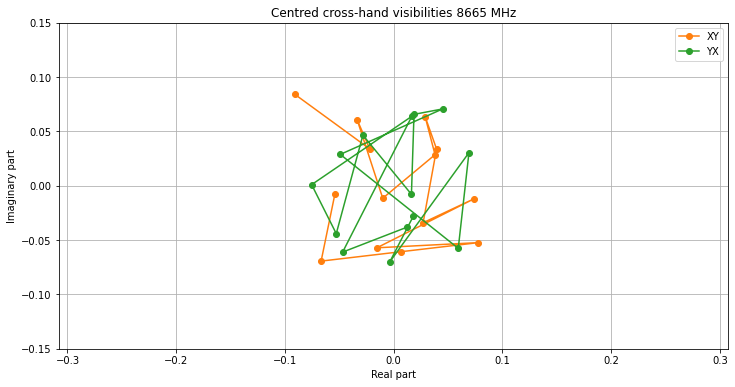

In [30]:
XY = {f: V4[f][:,1:3] - np.average(V4[f][:,1:3], axis = 0) for f in frequencies}
for f in frequencies:
    plt.figure()
    plt.plot(XY[f][:,0].real, XY[f][:,0].imag, 'o-', color = 'C1')
    plt.plot(XY[f][:,1].real, XY[f][:,1].imag, 'o-', color = 'C2')
    plt.axis('equal')
    a = 0.15
    plt.ylim((-a,a))
    plt.xlim((-a,a))
    plt.grid()
    plt.legend(visib_legend[1:-1])
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.title(f'Centred cross-hand visibilities {f:.0f} MHz')

To determine the line through the origin on which each cross-hand lies, we compute the eigenvector of the covariance matrix that corresponds to the largest eigenvalue. The angle of this vector gives us the X-Y phase offset, and allows us to rotate the cross-hands so that the lie along the real axis.

There is a 180º ambiguity in the determination of the angle from this straght line. We include here some additional 180º rotations so that things match up later with the source parallactic angle rotation and the XX - YY term. In general, we would proceed without applying this corrections, note when things don't match up, and then come back here and apply the necessary 180º rotations.

In [31]:
A = {f: np.vstack((XY[f][:,0].real, XY[f][:,0].imag)) for f in frequencies}
vXY = {f: np.linalg.eigh(np.cov(A[f]))[1][:,1] for f in frequencies}
A = {f: np.vstack((XY[f][:,1].real, XY[f][:,1].imag)) for f in frequencies}
vYX = {f: np.linalg.eigh(np.cov(A[f]))[1][:,1] for f in frequencies}
phiXY = {f: vXY[f][0] + 1j*vXY[f][1] for f in frequencies}
phiYX = {f: -(vYX[f][0] + 1j*vYX[f][1]) for f in frequencies}

# adjust 180º ambiguities
phiYX[6663] *= -1
for f in frequencies[:-3]:
    phiXY[f] *= -1
    phiYX[f] *= -1

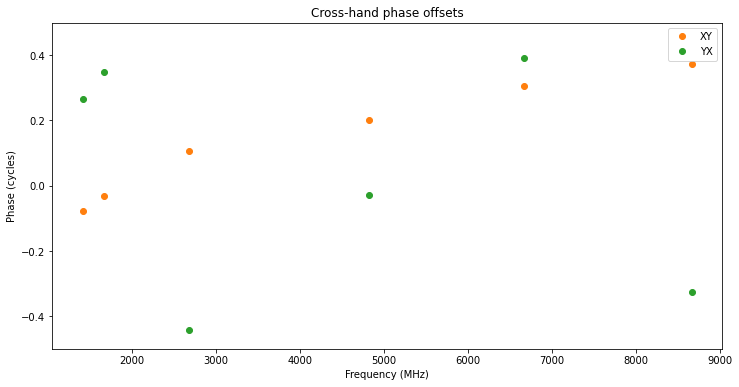

In [32]:
plt.plot(frequencies, [np.angle(phiXY[f])/(2*np.pi) for f in frequencies], 'o', color = 'C1')
plt.plot(frequencies, [np.angle(phiYX[f])/(2*np.pi) for f in frequencies], 'o', color = 'C2')
plt.title('Cross-hand phase offsets')
plt.ylabel('Phase (cycles)')
plt.ylim((-0.5,0.5))
plt.xlabel('Frequency (MHz)')
plt.legend(visib_legend[1:-1]);

Below we show the cross-hands after they have been moved to the origin and rotated.

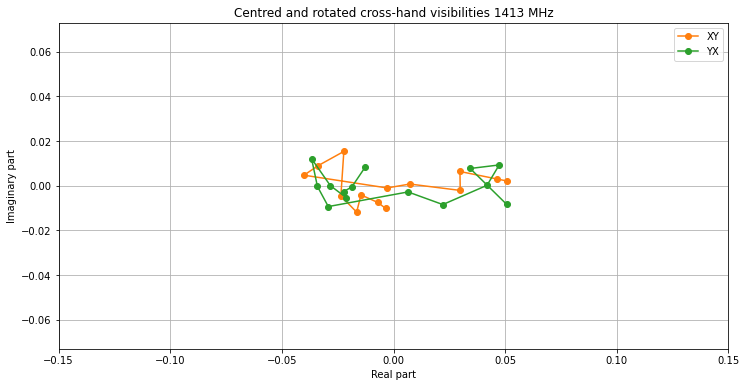

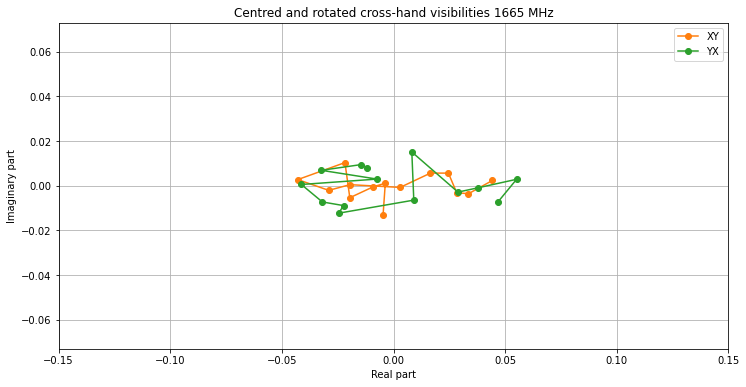

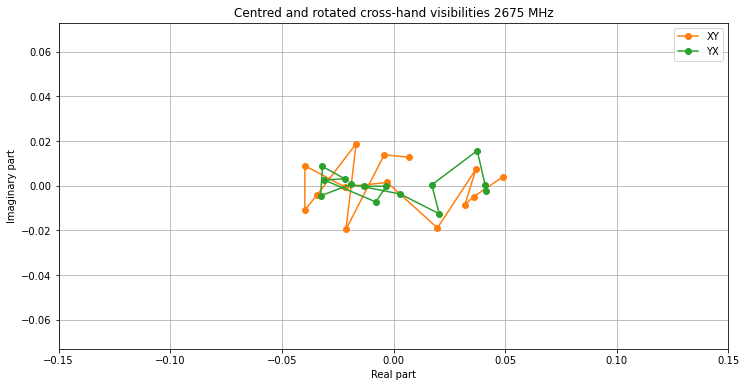

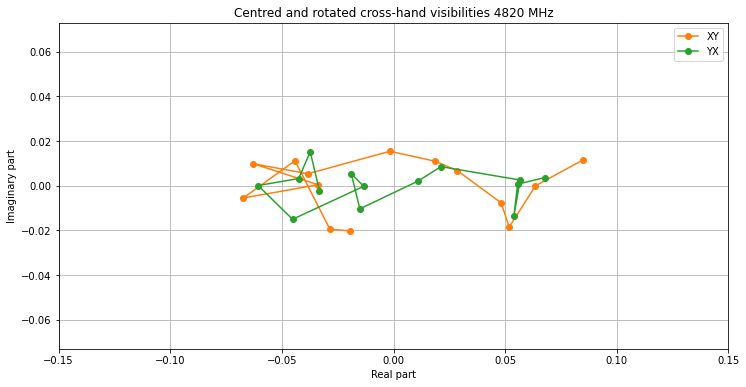

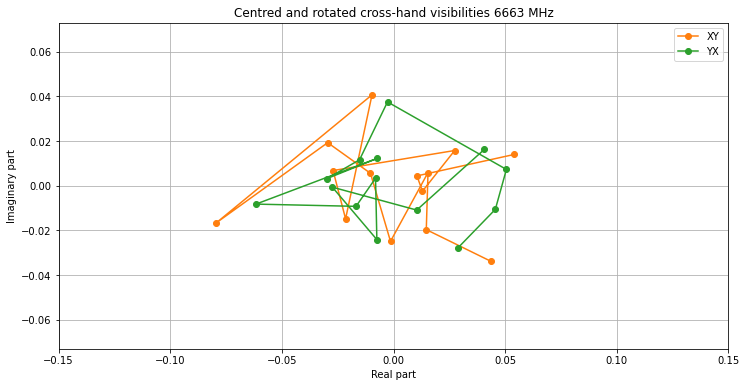

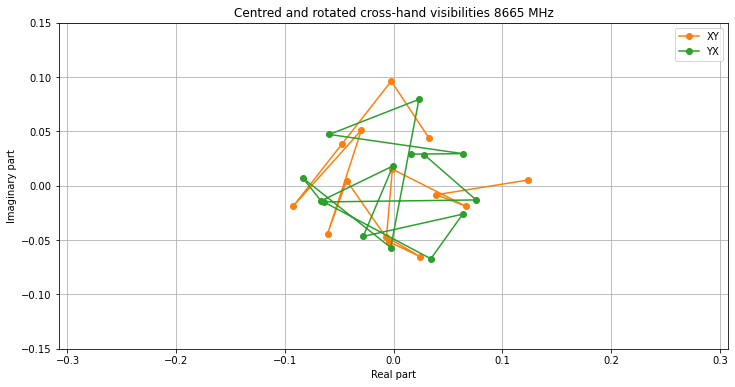

In [33]:
phi_corr = {f: np.conjugate(np.array([phiXY[f], phiYX[f]])) for f in frequencies}
XYr = {f: phi_corr[f] * XY[f] for f in frequencies}
for f in frequencies:
    plt.figure()
    plt.plot(XYr[f][:,0].real, XYr[f][:,0].imag, 'o-', color = 'C1')
    plt.plot(XYr[f][:,1].real, XYr[f][:,1].imag, 'o-', color = 'C2')
    plt.axis('equal')
    a = 0.15
    plt.ylim((-a,a))
    plt.xlim((-a,a))
    plt.grid()
    plt.legend(visib_legend[1:-1])
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.title(f'Centred and rotated cross-hand visibilities {f:.0f} MHz')

If we apply the same rotation to the original cross-hands, we obtain something that lies on a horizontal line that does not pass through the origin in general. This is shown below. The translation of the cross-hands is caused by the D-terms.

In [34]:
V5 = {f: V4[f].copy() for f in frequencies}
for f in frequencies:
    V5[f][:,1:3] *= phi_corr[f]

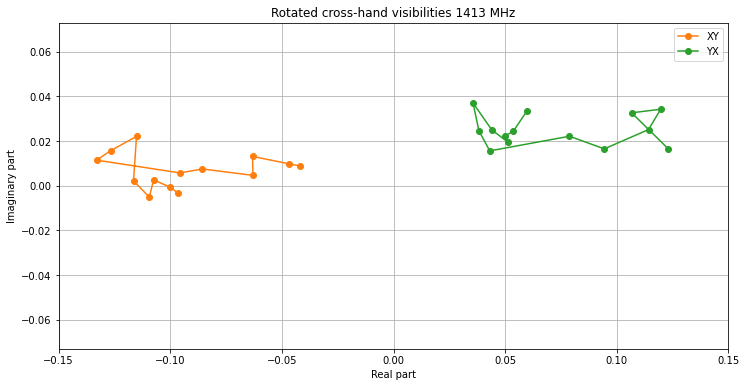

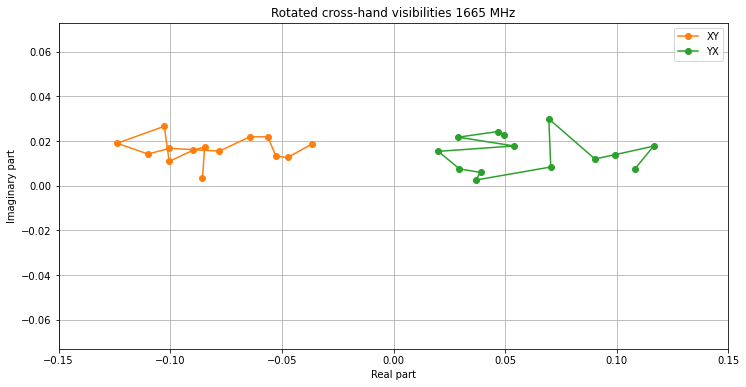

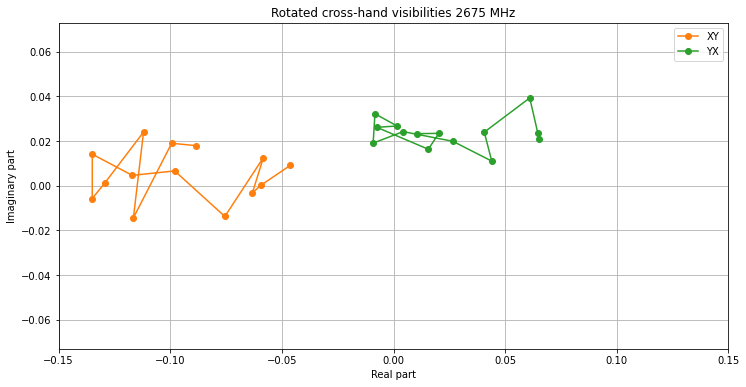

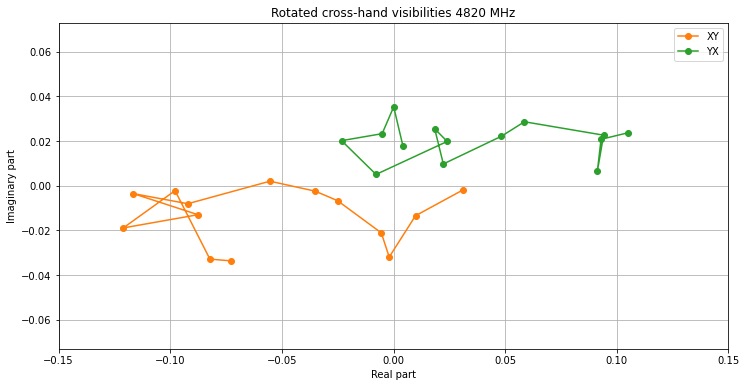

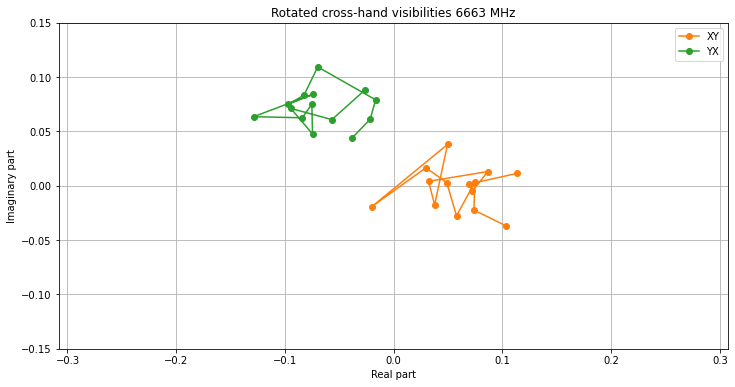

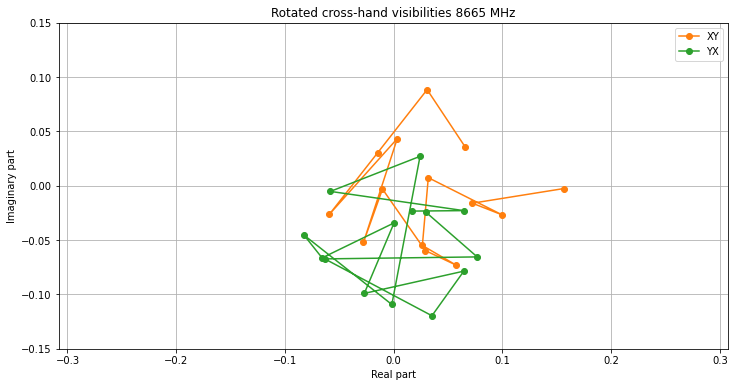

In [35]:
phi_corr = {f: np.conjugate(np.array([phiXY[f], phiYX[f]])) for f in frequencies}
XYr = {f: phi_corr[f] * XY[f] for f in frequencies}
for f in frequencies:
    plt.figure()
    plt.plot(V5[f][:,1].real, V5[f][:,1].imag, 'o-', color = 'C1')
    plt.plot(V5[f][:,2].real, V5[f][:,2].imag, 'o-', color = 'C2')
    plt.axis('equal')
    a = 0.15
    plt.ylim((-a,a))
    plt.xlim((-a,a))
    plt.grid()
    plt.legend(visib_legend[1:-1])
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')
    plt.title(f'Rotated cross-hand visibilities {f:.0f} MHz')

We now plot the real part of these rotated cross-hand visibilities. If the D-terms were zero, the XY and YX would coincide and give the U stokes parameter of the source. However, the real part of the D-terms causes an offset to these curves.

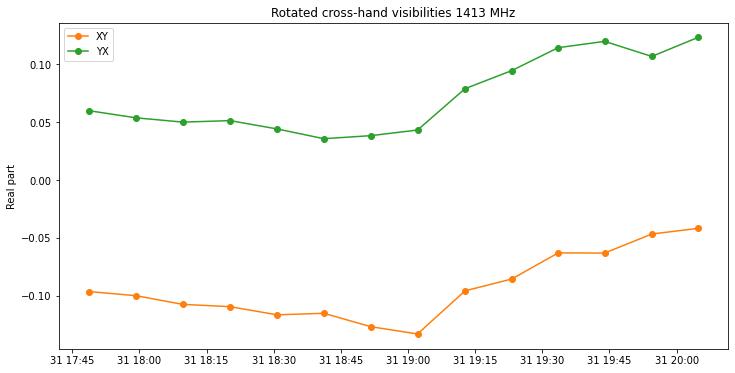

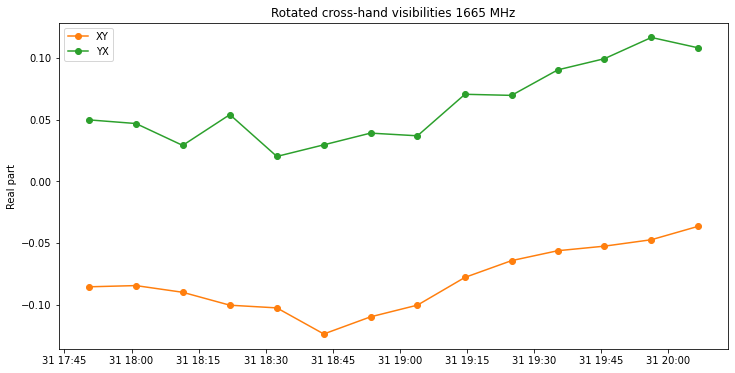

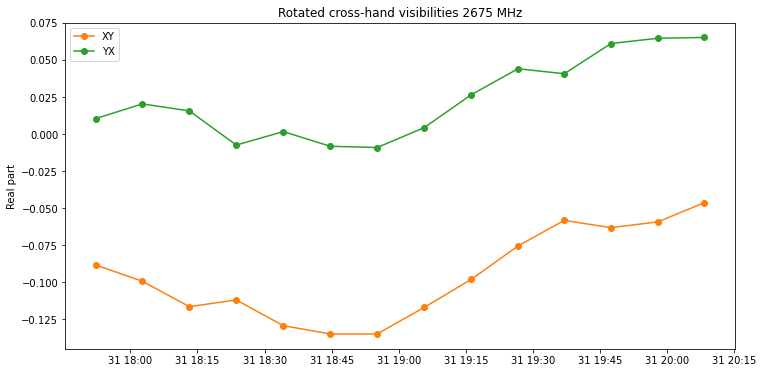

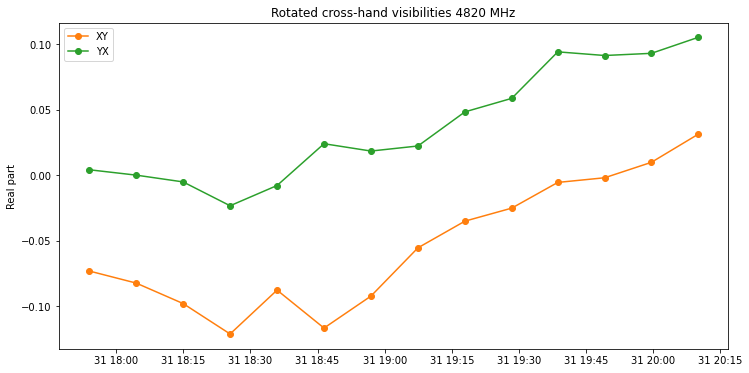

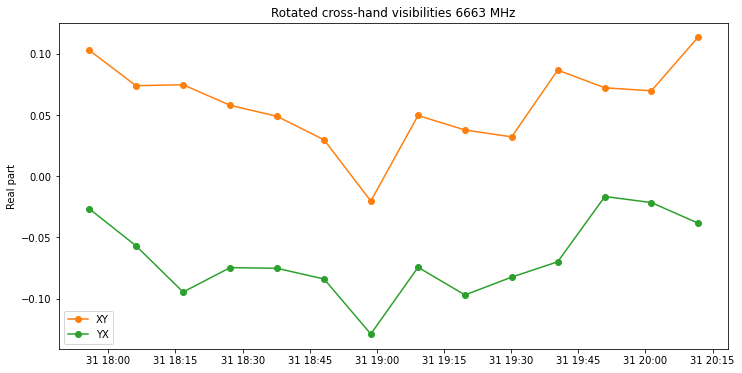

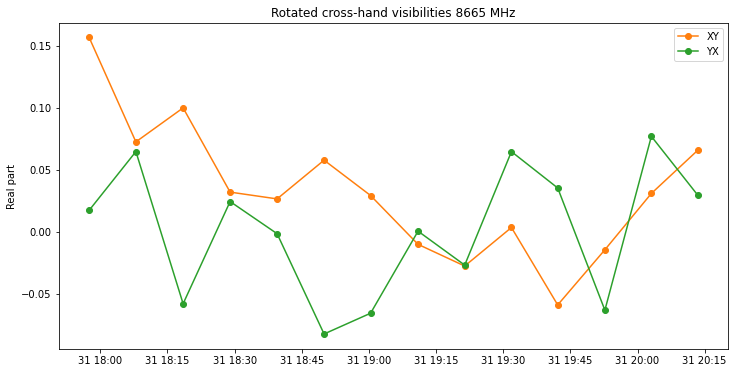

In [36]:
for f in frequencies:
    plt.figure()
    plt.plot(midpoint_timestamps[f].datetime, V5[f][:,1].real, 'o-', color = 'C1')
    plt.plot(midpoint_timestamps[f].datetime, V5[f][:,2].real, 'o-', color = 'C2')
    plt.legend(visib_legend[1:-1])
    plt.title(f'Rotated cross-hand visibilities {f:.0f} MHz')
    plt.ylabel('Real part')

The sum of the leakages (D-terms) can be obtained as the difference between the XY and YX cross-hands. We include this as a curiosity, since it is not included in the calibration.

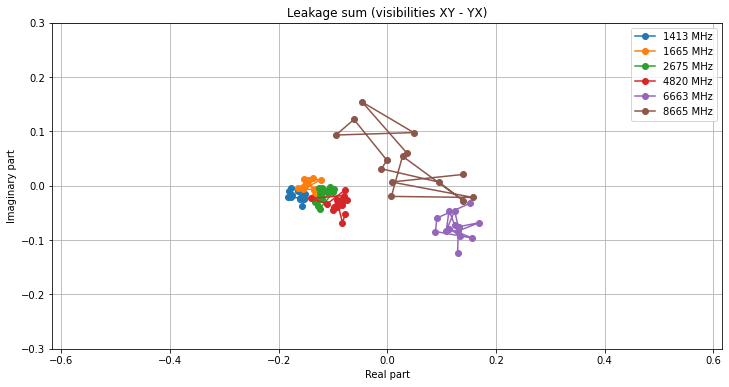

In [37]:
XYYX = {f : V5[f][:,1] - V5[f][:,2] for f in frequencies}
for f in frequencies:
    plt.plot(XYYX[f].real, XYYX[f].imag, 'o-')
plt.axis('equal')
a = 0.3
plt.ylim((-a,a))
plt.xlim((-a,a));
plt.grid()
plt.title('Leakage sum (visibilities XY - YX)')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.legend(freq_legend);

In [38]:
leak_sum = {f: np.average(XYYX[f]) for f in frequencies}
leak_sum

{1413.0: (-0.1652401463183839-0.018205792309429786j),
 1665.0: (-0.14229589778434645+0.0014273900349752668j),
 2675.0: (-0.1187646773807374-0.018448078109182153j),
 4820.0: (-0.09113382839000085-0.03351345029835893j),
 6663.0: (0.1263510911590667-0.07448110454494508j),
 8665.0: (0.0320185058870448+0.04458521302048669j)}

We can now give an approximation to stokes L = Q + iU by using XX - YY to approximate Q and the XY+YX to approximate U. The points in this approximation of L will lie in a circle, because of the parallactic angle rotation. If everything was calibrated correctly, the circle would be centred on the origin. However, a difference of gains between XX and YY will bias the estimate of Q and so the circle will be shifted horizontally. The difference of D-terms shows up in XY+YX, biasing the estimate of U and shifting the circle vertically.

We fit a circle to the estimate of L and use the centre of the circle to refine the gain difference between XX and YY and to calibrate out the D-terms.

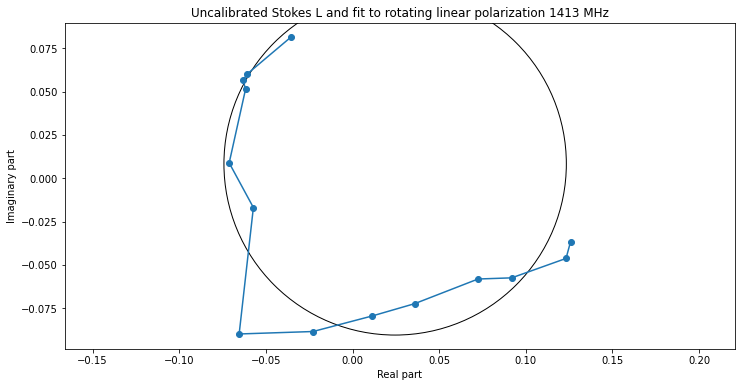

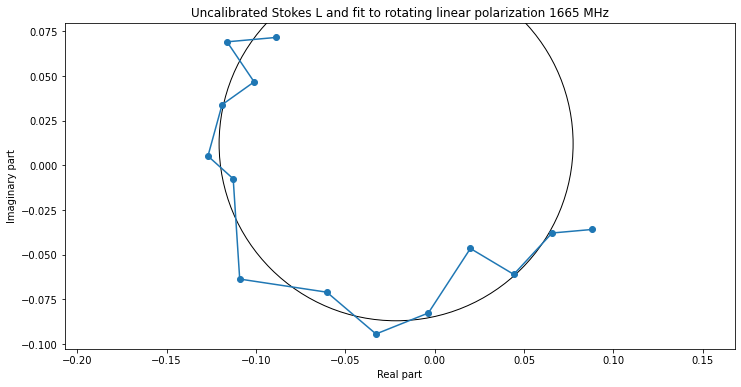

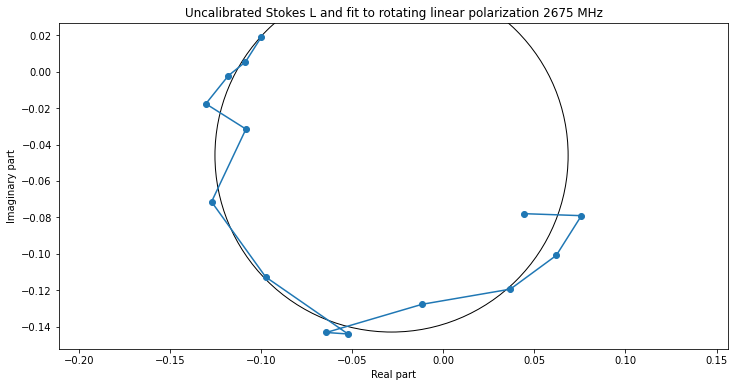

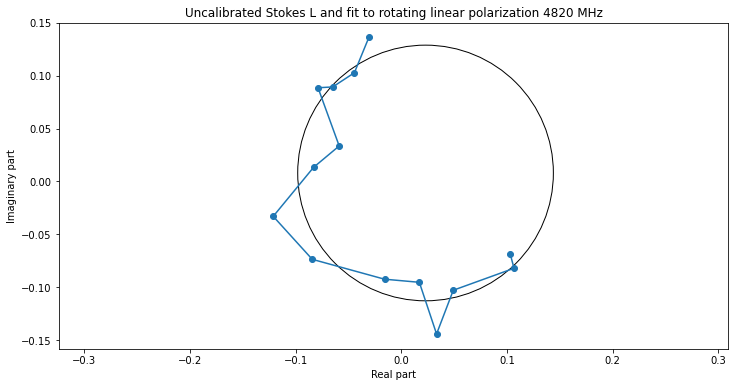

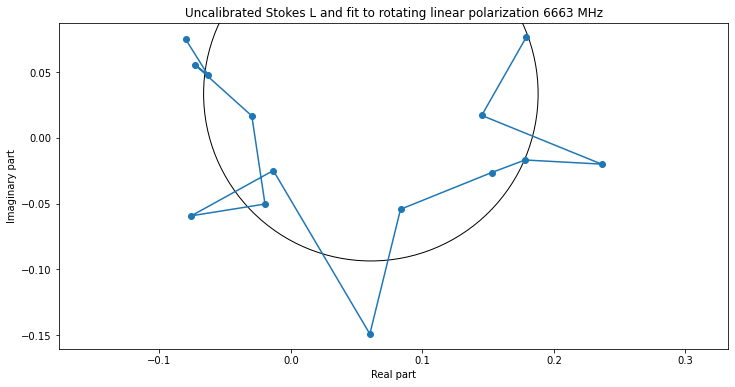

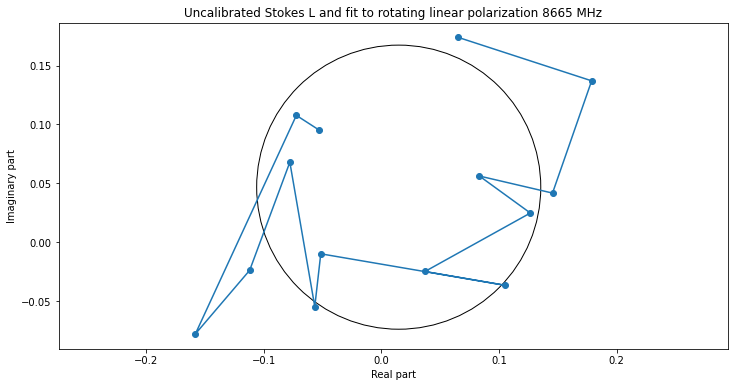

In [39]:
L = {f: (V5[f][:,0]-V5[f][:,3]).real + 1j*(V5[f][:,1]+V5[f][:,2]).real
     for f in frequencies}
def cost_function(x, f):
    z0 = x[0] + 1j*x[1]
    r = x[2]
    return np.sum((np.abs(L[f]-z0)-r)**2)
optimize = {f : scipy.optimize.least_squares(lambda x: cost_function(x,f), [0,0,0.05])
            for f in frequencies}

for f in frequencies:
    plt.figure()
    plt.plot(L[f].real, L[f].imag, 'o-')
    plt.axis('equal');
    plt.gca().add_artist(plt.Circle((optimize[f].x[0],optimize[f].x[1]),optimize[f].x[2], fill = False))
    plt.title(f'Uncalibrated Stokes L and fit to rotating linear polarization {f:.0f} MHz')
    plt.xlabel('Real part')
    plt.ylabel('Imaginary part')

Here is the gain difference between XX and YY, obtained from the centre of the circles shown above.

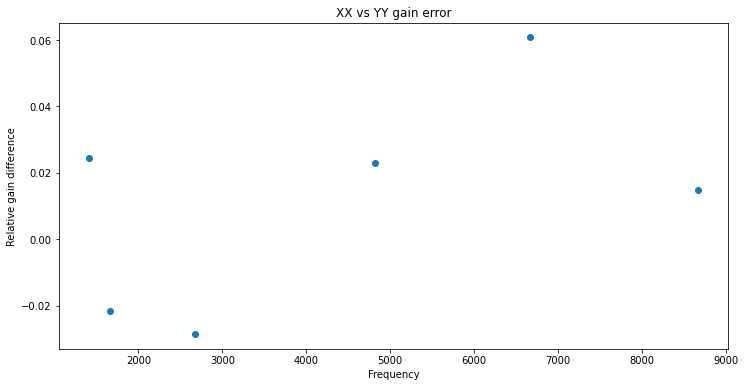

In [40]:
plt.plot(frequencies, [optimize[f].x[0] for f in frequencies], 'o')
plt.title('XX vs YY gain error')
plt.ylabel('Relative gain difference')
plt.xlabel('Frequency');

Here is the difference of D-terms, obtained from the circles shown above.

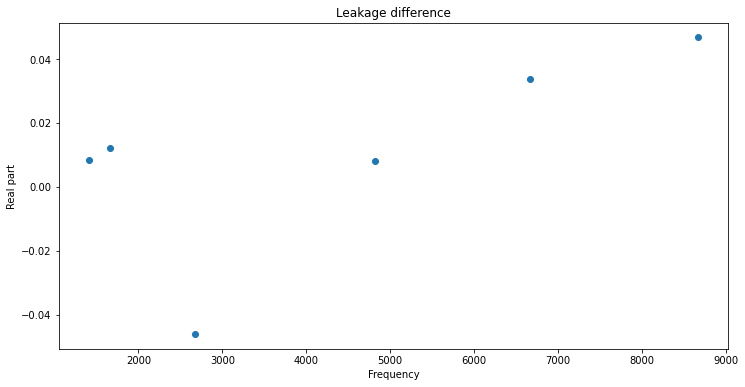

In [41]:
plt.plot(frequencies, [optimize[f].x[1] for f in frequencies], 'o')
plt.title('Leakage difference')
plt.ylabel('Real part')
plt.xlabel('Frequency');

Now we can correct for the gain offset between XX and YY and remove the D-term difference in the estimate of U, obtaining a much better estimate for L. We fit a circle centred on the origin to this estimate. The radius of this circle gives the fractional polarized intensity.

In [42]:
V6 = {f: V5[f].copy() for f in frequencies}
for f in frequencies:
    V6[f][:,3] *= 1 + optimize[f].x[0]/0.5
    V6[f][:,1] -= optimize[f].x[1]/2 + 1j*np.average(V5[f][:,1].imag)
    V6[f][:,2] -= optimize[f].x[1]/2 + 1j*np.average(V5[f][:,2].imag)
    V6[f][:,1] -= np.average(V5[f][:,1].real-V5[f][:,2].real)/2
    V6[f][:,2] += np.average(V5[f][:,1].real-V5[f][:,2].real)/2
    V6[f][:] /= (V6[f][:,0].real + V6[f][:,3].real)[:,np.newaxis]

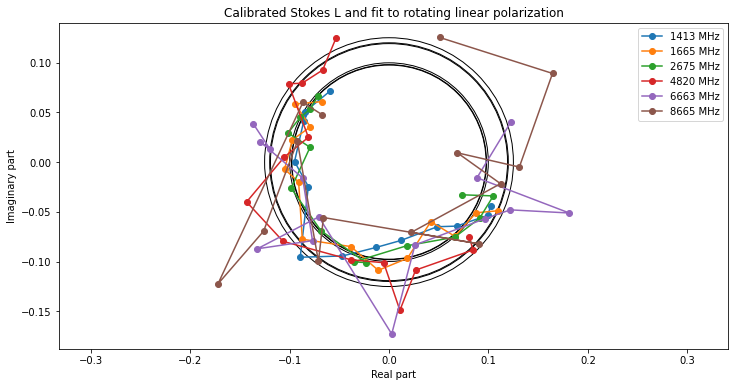

In [43]:
L = {f: (V6[f][:,0]-V6[f][:,3]).real + 1j*(V6[f][:,1]+V6[f][:,2]).real for f in frequencies}
rho = {f : np.average(np.abs(L[f])) for f in frequencies}
for f in frequencies:
    plt.plot(L[f].real, L[f].imag, 'o-')
    plt.axis('equal');
    plt.gca().add_artist(plt.Circle((0,0),rho[f], fill = False))
plt.legend(freq_legend)
plt.title('Calibrated Stokes L and fit to rotating linear polarization')
plt.xlabel('Real part')
plt.ylabel('Imaginary part');

The plot below shows the fractional polarized intensity, obtained from the radii of the circles shown above. We see that it is quite close to the values around 10% given by the VLA observations from January 2019.

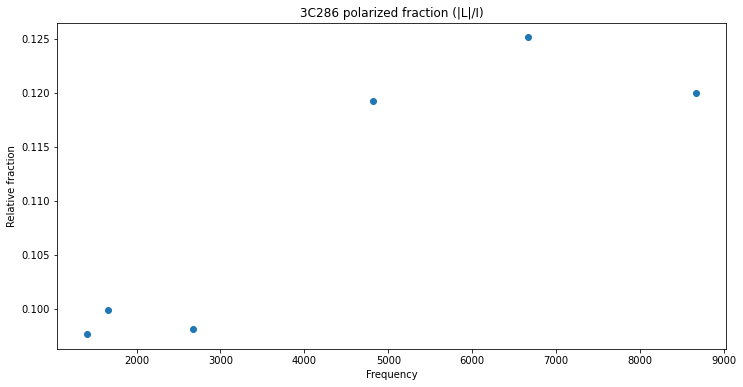

In [44]:
plt.plot(frequencies, [rho[f] for f in frequencies], 'o')
plt.title('3C286 polarized fraction (|L|/I)')
plt.ylabel('Relative fraction')
plt.xlabel('Frequency');

Now we perform parallactic angle correction to determine the polarization angle. If we rotate the Stokes L for each of the scans by the appropriate angle coming from the source parallactic angle, we would spect all the values of Stokes L to be equal. We compute the average angle. The plot below shows the angle residuals, which are around 10 degrees.

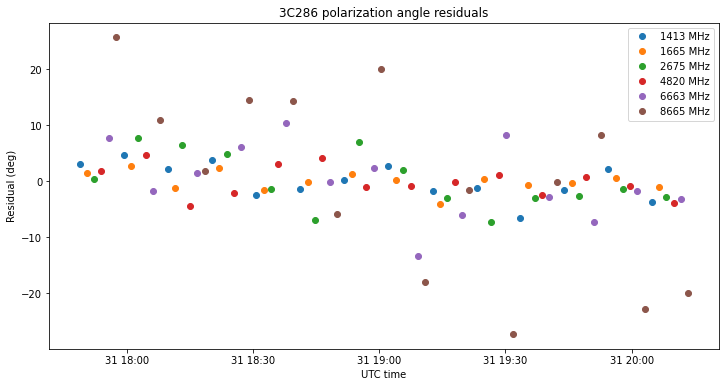

In [45]:
theta = {f: np.unwrap(np.angle(-L[f]*np.exp(1j*2*parallactic_angle[f].rad)))/2
         for f in frequencies}
theta0 = {f: np.average(theta[f]) for f in frequencies}
for f in frequencies:
    plt.plot(midpoint_timestamps[f].datetime, np.rad2deg(theta[f]-theta0[f]), 'o')
plt.title('3C286 polarization angle residuals')
plt.ylabel('Residual (deg)')
plt.xlabel('UTC time')
plt.legend(freq_legend);

Likewise, we expect the estimates of L obtained in all the scans to lie in the same circle, corresponding to a constant polarized intensity. The figure below shows the residuals.

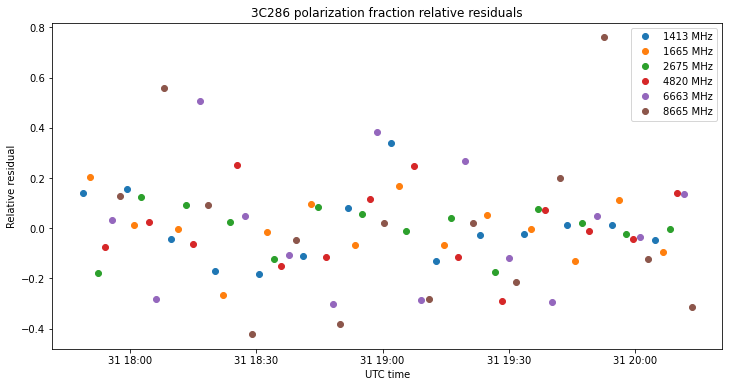

In [46]:
for f in frequencies:
    plt.plot(midpoint_timestamps[f].datetime, np.abs(L[f])/rho[f]-1, 'o')
plt.title('3C286 polarization fraction relative residuals')
plt.ylabel('Relative residual')
plt.xlabel('UTC time')
plt.legend(freq_legend);

In [47]:
vla_freqs = np.array([1.02, 1.47, 1.87, 2.57, 3.57, 4.89, 6.68, 8.43])*1e3
vla_degree = np.array([8.6, 9.8, 10.1, 10.6, 11.2, 11.5, 11.9, 12.1])/100
vla_angle = [33]*vla_freqs.size

To compare the results obtained in the simple calibration performed above with those obtained by professional software, we have performed a full polarimetric calibration in CASA and obtained the values below.

In [48]:
casa_degree = np.array([0.1014316, 0.09574746, 0.09262334, 0.1023586, 0.07860215, 0.13382925])
casa_angle = np.array([27.68144777, 27.38137797, 31.71887392, 20.00797201, 45.31886343, 53.30739212])

The figure below compares the polarization degree (I/|L|) measured in this study, both with this notebook and with CASA with the observations from VLA. Interestingly, the values obtained in this notebook seem to follow the VLA observations more closely that those obtained with CASA.

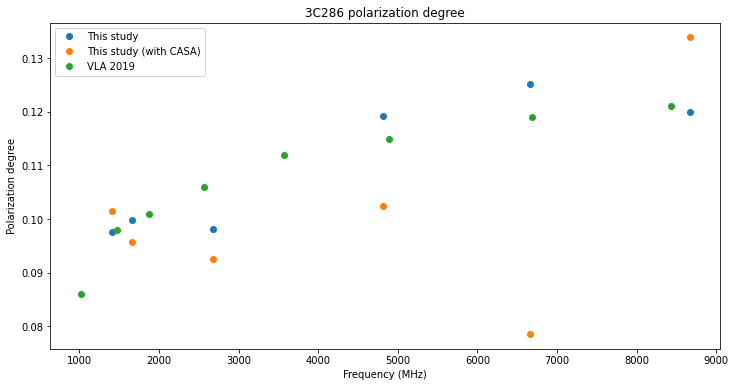

In [49]:
plt.plot(frequencies, [rho[f] for f in frequencies], 'o', label = 'This study')
plt.plot(frequencies, casa_degree, 'o', label = 'This study (with CASA)')
plt.plot(vla_freqs, vla_degree, 'o', label = 'VLA 2019')
plt.ylabel('Polarization degree')
plt.legend()
plt.title('3C286 polarization degree')
plt.xlabel('Frequency (MHz)');

Next we compare the polarization angle obtained in this study with the polarization angle measured by VLA, which is 33 degrees for this range of frequencies. The angles obtained with this notebook and CASA are pretty similar. Note that we have not corrected Faraday rotation. However, Faraday rotation is small: typically 5 degrees or less at 1.4 GHz, and it decays with the square of the frequency.

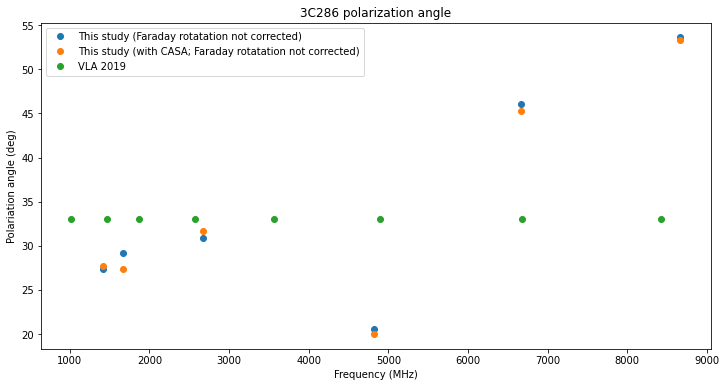

In [50]:
plt.plot(frequencies, [np.rad2deg(theta0[f]) for f in frequencies], 'o',
            label = 'This study (Faraday rotatation not corrected)')
plt.plot(frequencies, casa_angle, 'o',
            label = 'This study (with CASA; Faraday rotatation not corrected)')
plt.plot(vla_freqs, vla_angle, 'o', label = 'VLA 2019')
plt.legend()
plt.title('3C286 polarization angle')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Polariation angle (deg)');